In [80]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [81]:
bolTrainagain = False # will try to load data if false 

In [82]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=2
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
# needs treshold  3 QuatreCamins, 2 SantBoi,  7 Mollet 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  5039.12719298242
Friday area:  4900.933333333347
Weekend area:  2268.3541666666724
Weekday maximum:  199.89473684210526
Friday maximum:  189.8
Weekend maximum:  115.875


## MATHEMATICAL MODEL - CDF Subtraction

In [83]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

#parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if not(bolTrainagain):
    try:
        with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
            [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
             errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
            f.close()
    except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
        print('no saved data: recalcualting')
        bolTrainagain = True

if bolTrainagain:
    errors_wd = np.ones(np.shape(training_weekdays_norm))

    parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*wd_length)

    optimal_params_weekdaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_weekdays_norm,training_weekdays_isfull,errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


In [84]:
var_weekdaytn_time = np.mean(errors_wd)
#var_weekdaytn = optimal_params_weekdaytn.fun/np.size(training_weekdays_norm)
stdv_weekdaytn=math.sqrt(var_weekdaytn_time)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.05752



In [85]:
optimal_params_weekdaytn

 final_simplex: (array([[0.33299973, 0.05661486, 0.84627709, 0.08834803, 0.82148642,
        0.83080365, 0.82074921, 0.77440103, 0.77972365, 0.79536875,
        0.77059473, 0.80326677, 0.78683975, 0.77059473, 0.7594931 ,
        0.71513527, 0.73172742, 0.74231527, 0.72695706, 0.69363208,
        0.67825952, 0.69562348, 0.6952921 ],
       [0.33299973, 0.05661486, 0.84627709, 0.08834808, 0.82148667,
        0.83080397, 0.82074941, 0.77440084, 0.77972335, 0.79536831,
        0.77059487, 0.80326662, 0.78683967, 0.77059487, 0.75949318,
        0.71513531, 0.73172736, 0.74231524, 0.72695724, 0.69363221,
        0.6782596 , 0.69562356, 0.69529193],
       [0.33299974, 0.05661484, 0.8462771 , 0.08834802, 0.82148639,
        0.83080378, 0.82074913, 0.77440103, 0.77972357, 0.79536847,
        0.77059485, 0.80326649, 0.78683986, 0.77059485, 0.75949352,
        0.71513537, 0.73172743, 0.74231558, 0.72695712, 0.69363209,
        0.67825964, 0.69562364, 0.69529202],
       [0.33299972, 0.05661486, 

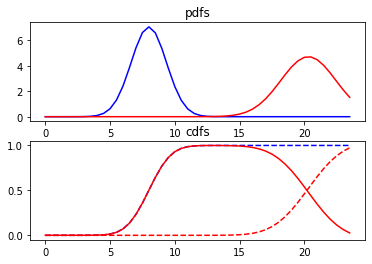

In [86]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [87]:
optimal_params_weekdayth=np.mean(optimal_params_weekdaytn.x[4:])

In [88]:
optimal_params_weekdayth

0.7574875794139243

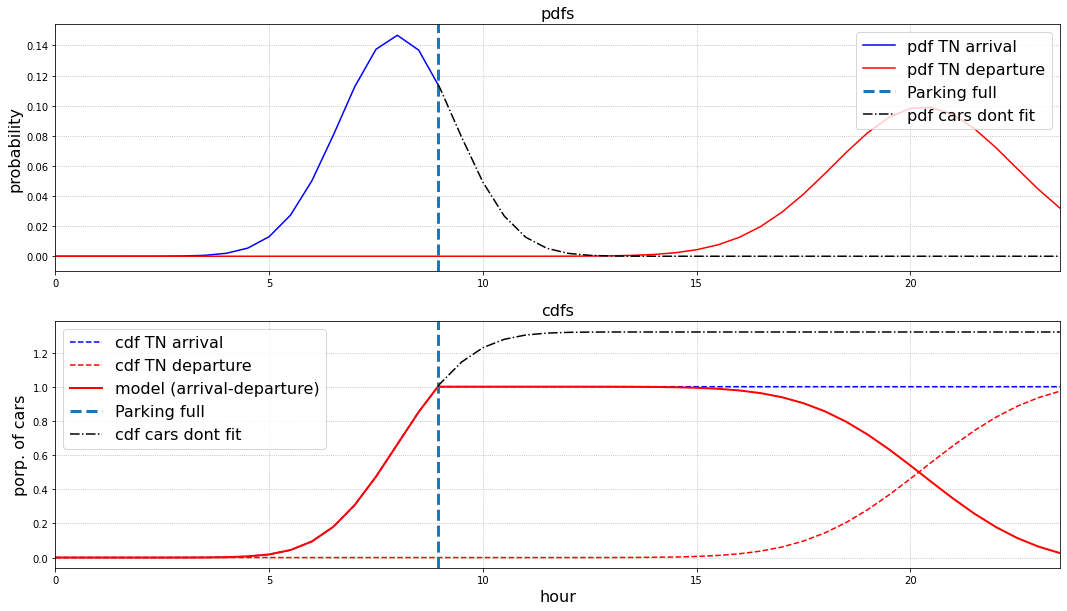

In [89]:
fid=plot_model_tn_thDisc(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],
              optimal_params_weekdaytn.x[3],optimal_params_weekdayth)
fid.savefig('Model_'+current_parking+'.pdf',bbox_inches='tight');

In [90]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.33299973, 0.05661486, 0.84627709, 0.08834803, 0.82148642,
       0.83080365, 0.82074921, 0.77440103, 0.77972365, 0.79536875,
       0.77059473, 0.80326677, 0.78683975, 0.77059473, 0.7594931 ,
       0.71513527, 0.73172742, 0.74231527, 0.72695706, 0.69363208,
       0.67825952, 0.69562348, 0.6952921 ])

In [91]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
prototype_math_arr_weekday=cdf1_wd
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
prototype_math_dep_weekday=cdf2_wd
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd#/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")
#plt.plot(time2, cdf1_wd_ap, label="Cummulative probability arrival approx")
#plt.plot(time2, cdf2_wd_ap, label="Cummulative probability departure approx")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


In [92]:
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])

ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdayth)
t_parking_full=np.interp(optimal_params_weekdayth,cdf1_wd,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)

tn1_wd_unmodifed=tn1_wd
tn1_wd=np.insert(tn1_wd,ix_parking_full,np.interp(t_parking_full,time2,tn1_wd))
tn1_wd_excees=tn1_wd.copy()
tn1_wd[ix_parking_full+1:] =0
tn1_wd_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_wd), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_wd), dtype=bool)
masktn1_excees[:ix_parking_full] =False

#tn1_wd[cdf1_wd>optimal_params_weekdayth] =0
#tn1_wd_excees[cdf1_wd<optimal_params_weekdayth] =0
cdf1_wd[cdf1_wd>optimal_params_weekdayth] = optimal_params_weekdayth
cdf1_wd_plot=np.insert(cdf1_wd,ix_parking_full,optimal_params_weekdayth)

cdf1_wd = cdf1_wd/optimal_params_weekdayth
cdf1_wd_plot = cdf1_wd_plot/optimal_params_weekdayth

cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
cdf2_wd_plot=np.insert(cdf2_wd,ix_parking_full,np.interp(t_parking_full,time2,cdf2_wd))
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
resta_wd_plot = np.array(cdf1_wd_plot) - np.array(cdf2_wd_plot)
prototype_math_weekday = resta_wd#/sum(resta_wd)
prototype_math_weekday_plot = resta_wd_plot#/sum(resta_wd)
#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2_th[masktn1], tn1_wd[masktn1]/sum(tn1_wd_unmodifed), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2_th, cdf1_wd_plot, label="Cummulative probability arrival")
#plt.plot(time2_th, cdf2_wd_plot, label="Cummulative probability departure")

#plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2_th[masktn1_excees], tn1_wd_excees[masktn1_excees]/sum(tn1_wd_unmodifed),'-.',
#         label="Excess Probability")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");

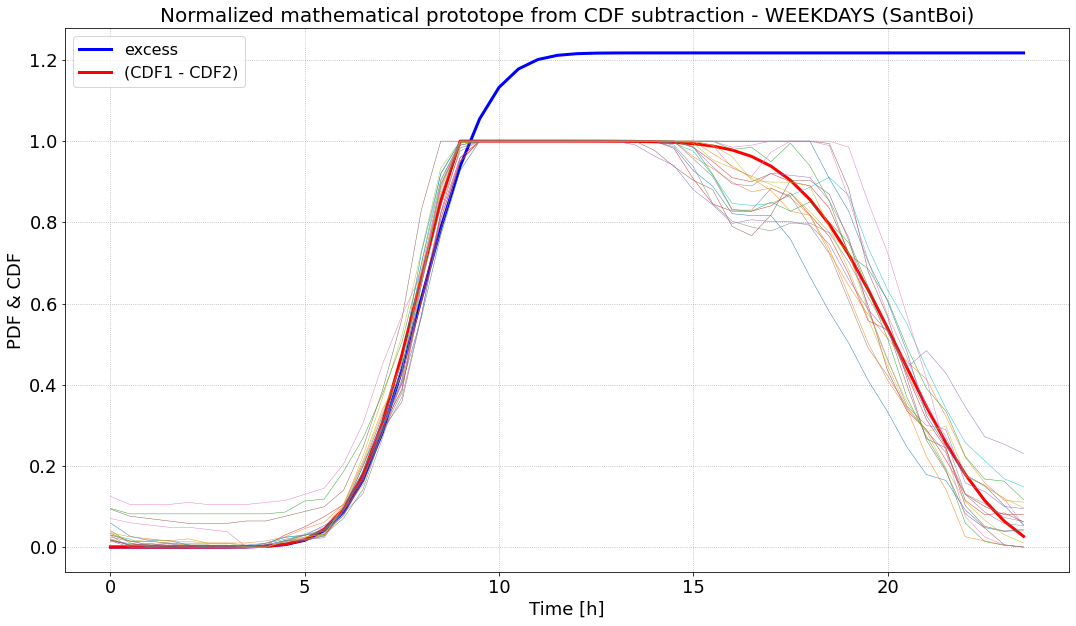

In [93]:
fig = plt.figure(figsize=(18,10))
plt.title("Normalized mathematical prototope from CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time2, prototype_math_arr_weekday/optimal_params_weekdaytn.x[4], linewidth=3, color='blue', label="excess")
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    plt.plot(time, training_weekdays_norm[i], linewidth=0.45)

plt.legend(fontsize=16, loc="upper left");

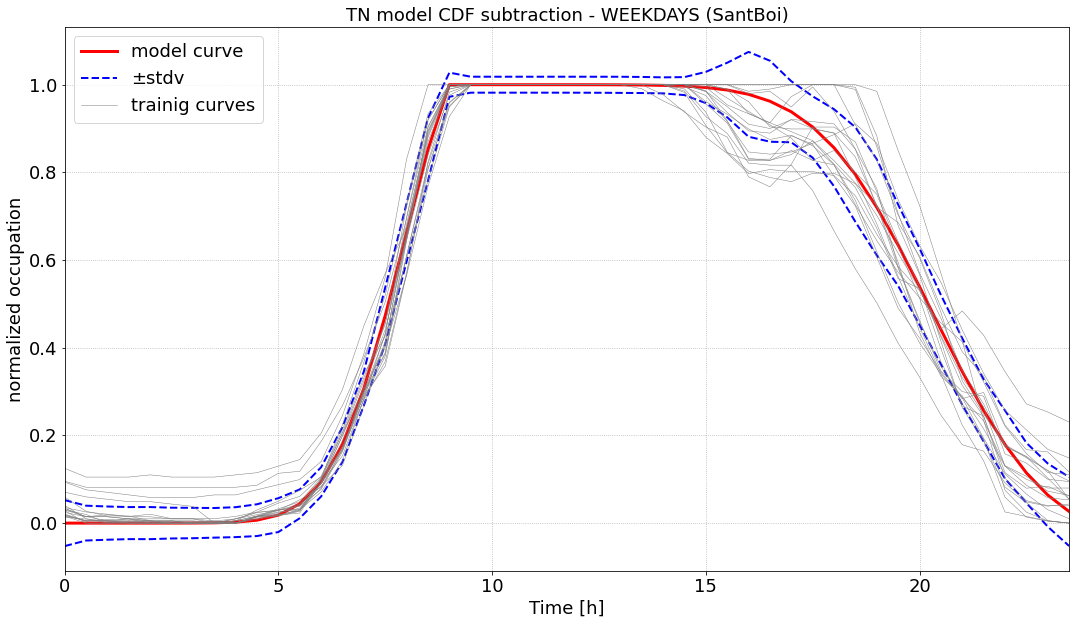

In [94]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

In [95]:
bol_plot_individual_fits = False
if bol_plot_individual_fits: 
    tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
    tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    for ii in range(0,len(training_weekdays_norm)):
        idx_th=ii+4

        cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])


        dayisFull=training_weekdays_isfull[ii]
        if dayisFull:
            print(optimal_params_weekdaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] =0
            cdf1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] = optimal_params_weekdaytn.x[idx_th]
            cdf1_wd = cdf1_wd/optimal_params_weekdaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
        prototype_math_weekday = resta_wd#/sum(resta_wd)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - weekdayS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_weekdays_norm)):
        plt.plot(time, training_weekdays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### FRIDAYS

In [96]:
if bolTrainagain:
    errors_fr = np.ones(np.shape(training_fridays_norm))

    parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*f_length)
    optimal_params_fridaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_fridays_norm,training_fridays_isfull,errors_fr),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})



In [97]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
#print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.09073



In [98]:
optimal_params_fridaytn

 final_simplex: (array([[0.46155062, 0.09234591, 1.33795469, 0.3106662 , 0.14566305,
        0.1461362 , 0.11459842, 0.1039323 , 0.10440853],
       [0.46155027, 0.09234576, 1.33795544, 0.31066631, 0.14566344,
        0.14613659, 0.11459867, 0.10393262, 0.10440888],
       [0.46155051, 0.09234592, 1.33795415, 0.31066608, 0.14566334,
        0.14613652, 0.11459865, 0.10393268, 0.10440891],
       [0.46155054, 0.09234586, 1.33795498, 0.31066622, 0.14566319,
        0.14613638, 0.11459847, 0.1039324 , 0.10440864],
       [0.46155055, 0.09234593, 1.33795439, 0.31066602, 0.14566345,
        0.1461366 , 0.11459852, 0.10393257, 0.10440881],
       [0.4615504 , 0.09234585, 1.33795478, 0.31066622, 0.14566347,
        0.14613665, 0.11459855, 0.10393249, 0.10440875],
       [0.4615508 , 0.092346  , 1.3379541 , 0.31066601, 0.14566303,
        0.14613619, 0.11459837, 0.10393231, 0.10440857],
       [0.46155028, 0.09234579, 1.33795474, 0.31066629, 0.14566363,
        0.14613682, 0.11459867, 0.103932

In [99]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [100]:
optimal_params_fridaytn.x[4:]

array([0.14566305, 0.1461362 , 0.11459842, 0.1039323 , 0.10440853])

In [101]:
optimal_params_fridayth=np.mean(optimal_params_fridaytn.x[4:])

In [102]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta#/sum(resta)
#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

In [103]:
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
prototype_math_arr_friday=cdf1_fri.copy()

ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridayth)
t_parking_full=np.interp(optimal_params_fridayth,cdf1_fri,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)


tn1_fri_unmodifed=tn1_fri
tn1_fri=np.insert(tn1_fri,ix_parking_full,np.interp(t_parking_full,time2,tn1_fri))
tn1_fri_excees=tn1_fri.copy()
tn1_fri[ix_parking_full+1:] =0
tn1_fri_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_fri), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_fri), dtype=bool)
masktn1_excees[:ix_parking_full] =False

cdf1_fri[cdf1_fri>optimal_params_fridayth] = optimal_params_fridayth
cdf1_fri_plot=np.insert(cdf1_fri,ix_parking_full,optimal_params_fridayth)

cdf1_fri = cdf1_fri/optimal_params_fridayth
cdf1_fri_plot = cdf1_fri_plot/optimal_params_fridayth

cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])
cdf2_fri_plot=np.insert(cdf2_fri,ix_parking_full,np.interp(t_parking_full,time2,cdf2_fri))
prototype_math_dep_friday=cdf2_fri
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
resta_fri_plot = np.array(cdf1_fri_plot) - np.array(cdf2_fri_plot)
prototype_math_friday = resta_fri#/sum(resta_wd)
prototype_math_friday_plot = resta_fri_plot

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)

#plt.plot(time2_th[masktn1], tn1_fri[masktn1]/sum(tn1_fri_unmodifed), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.plot(time2_th, cdf1_fri_plot, label="Cummulative probability arrival")
#plt.plot(time2_th, cdf2_fri_plot, label="Cummulative probability departure")
#plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2_th[masktn1_excees], tn1_fri_excees[masktn1_excees]/sum(tn1_fri_unmodifed),'-.',
#         label="Excess Probability")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");

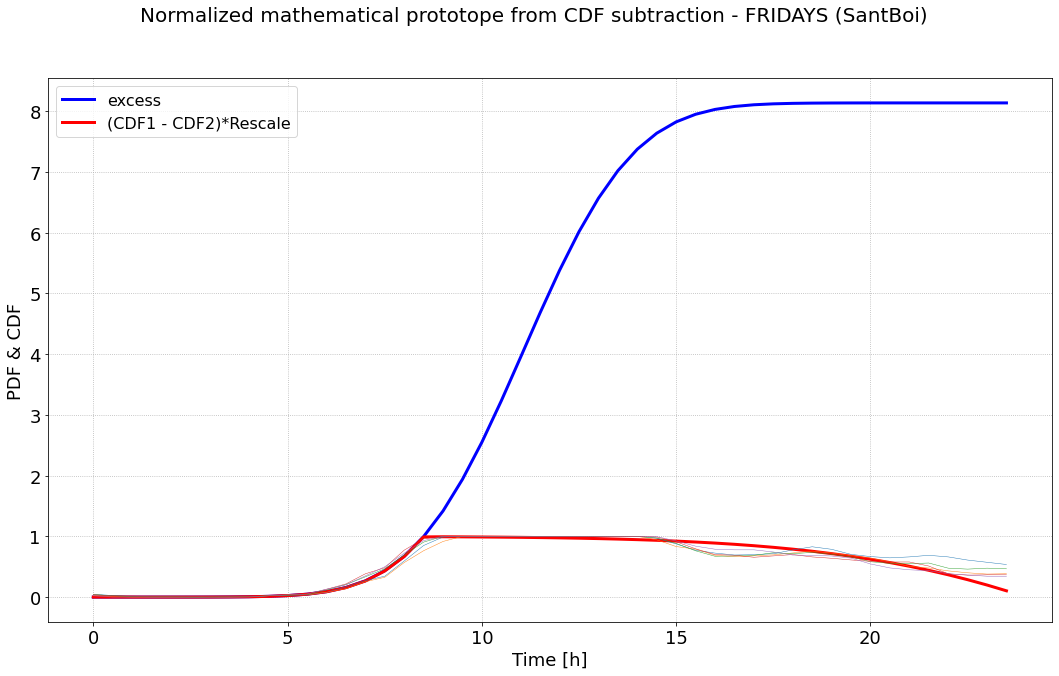

In [104]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time, prototype_math_arr_friday/optimal_params_fridayth, linewidth=3, color='blue', label="excess")
plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
for i in range(0,len(training_fridays_norm)):
    plt.plot(time, training_fridays_norm[i], linewidth=0.45)
plt.legend(fontsize=16);

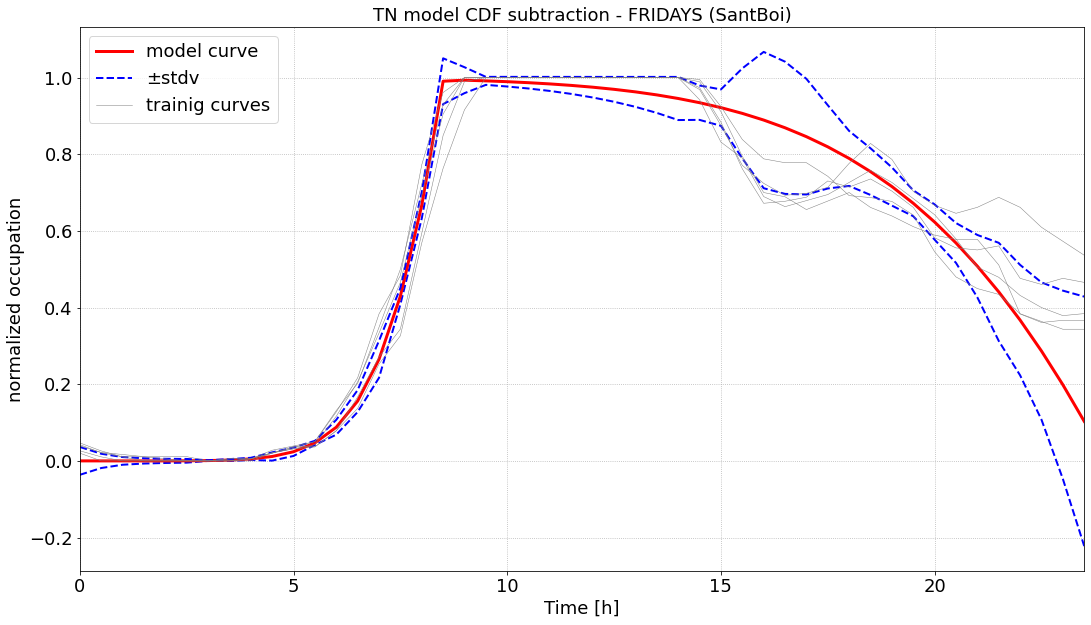

In [105]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

In [106]:
bol_plot_individual_fits = False
if bol_plot_individual_fits:
    tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
    tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    for ii in range(0,len(training_fridays_norm)):
        idx_th=ii+4

        cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])


        dayisFull=training_fridays_isfull[ii]
        if dayisFull:
            print(optimal_params_fridaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] =0
            cdf1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] = optimal_params_fridaytn.x[idx_th]
            cdf1_fri = cdf1_fri/optimal_params_fridaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
        prototype_math_friday = resta_fri#/sum(resta_fri)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_fridays_norm)):
        plt.plot(time, training_fridays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### WEEKENDS

In [107]:
parameters_tn = np.array([.2 ,.05,.7,.1])
if bolTrainagain:
    errors_we = np.ones(np.shape(training_weekends_norm))  
    if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
        optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors_we),
                                    method='SLSQP',
                                    bounds=((0, None), (0, None),(0, None),(0, None)),
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
    else:
        optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors_we),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


In [108]:
if bolTrainagain:
    #save modelparams and error
    with open('data/'+current_parking+'_modelFitTH.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we], f)
        f.close()
    
    # Getting back the objects:
    with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [109]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.32014



In [110]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([ 39.49039224,   9.48156606, 108.99453208,   3.229212  ])

In [111]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we#/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

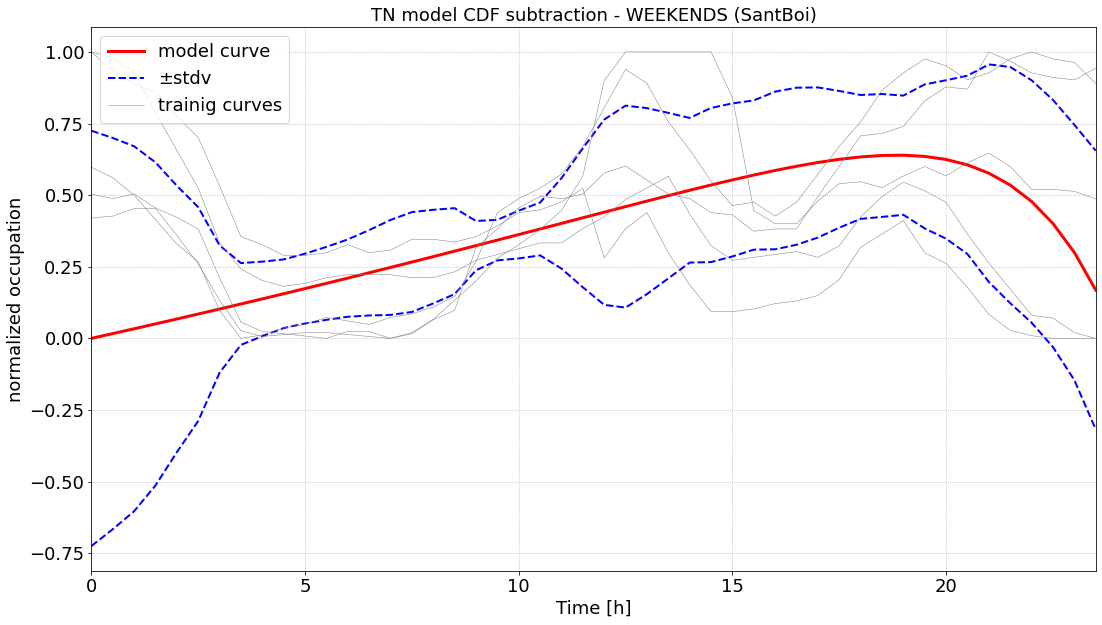

In [112]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [113]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS SantBoi -----------
Mean Arrival Time   = 07:59h
stdv Arrival        =  1:21h
Mean Departure Time = 20:18h
stdv Departure      =  2:07h
Parking full        = 09:00h
--------- FRIDAYS SantBoi -----------
Mean Arrival Time   = 11:04h
stdv Arrival        =  2:12h
Mean Departure Time = 32:06h
stdv Departure      =  7:27h
Parking full        = 09:00h
--------- WEEKENDS SantBoi -----------
Mean Arrival Time   = 947:46h
stdv Arrival        = 227:33h
Mean Departure Time = 2615:52h
stdv Departure      = 77:30h


In [114]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

tn_arr_weekday_n = prototype_math_arr_weekday
tn_dep_weekday_n = prototype_math_dep_weekday
tn_arr_friday_n = prototype_math_arr_friday
tn_dep_friday_n = prototype_math_dep_friday

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [115]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_max + weekday_offset
tn_arr_weekday = tn_arr_weekday_n*weekday_max + weekday_offset

tn_weekday_nooff = tn_weekday_n*weekday_max 
tn_arr_weekday_nooff = tn_arr_weekday_n*weekday_max 
tn_dep_weekday = tn_dep_weekday_n*weekday_max #+ weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_max + friday_offset
tn_arr_friday = tn_arr_friday_n*friday_max + friday_offset

tn_friday_nooff = tn_friday_n*friday_max
tn_arr_friday_nooff = tn_arr_friday_n*friday_max
tn_dep_friday = tn_dep_friday_n*friday_max #+ friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_max + weekend_offset 

tn1_weekend_nooff = tn1_weekend_n*weekend_max 

In [116]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

31 cars could not park
20 cars could not park
52 cars could not park
82 cars could not park
56 cars could not park
67 cars could not park
22 cars could not park
90 cars could not park
80 cars could not park
44 cars could not park
102 cars could not park
53 cars could not park
835 cars could not park
1067 cars could not park
155 cars could not park
______ MEAN ± STDV________
2.7967742303491447  ±  1.6431262567383784
2.4909119674021394  ±  1.7570848764922087
1.8780678460775733  ±  1.3113745463821733
2.0349498969849633  ±  1.0163740236177892
7.879982534390966  ±  4.364832601170573
4.519245684752462  ±  1.221391175736741
6.954307503753944  ±  3.078230024371581


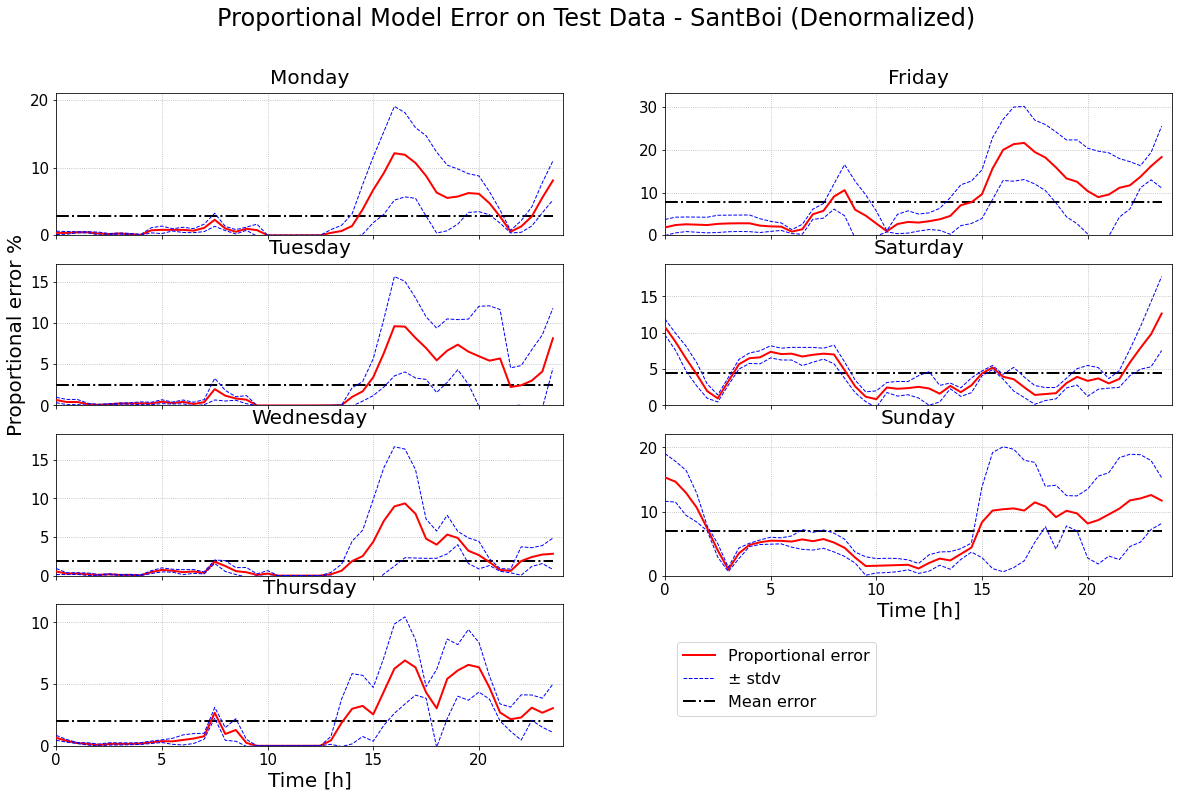

In [117]:

#[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv_fit(testing_mondays, tn_weekday, max_value)
#[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv_fit(testing_tuesdays, tn_weekday, max_value)
#[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv_fit(testing_wednesdays, tn_weekday, max_value)
#[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv_fit(testing_thursdays, tn_weekday, max_value)
#[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv_fit(testing_fridays, tn_friday, max_value)

[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_mondays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_tuesdays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_wednesdays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_thursdays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv_fitTh(testing_fridays, tn_arr_friday_nooff, tn_dep_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv_fit(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv_fit(testing_sundays, tn1_weekend, max_value)



    
fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday', 'Monday',False,False,False,False)


mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'th.pdf',bbox_inches='tight');
#ax[1,1].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))

#2.7099637370236747  ±  1.4736557849835552
#1.925942761285978  ±  0.9518195298543765
#4.466166164768858  ±  3.598647373249273
#4.958390536998728  ±  3.2336490787488423
#3.5121002753705888  ±  1.9714569641577306
#1.4446216223202166  ±  0.6038895057300911
#1.5398630128235424  ±  0.7823771802230111


#2.228801820252222  ±  1.2395925005732904
#1.609811647344771  ±  0.7446884490736162
#3.625330724308389  ±  3.1692274849228514
#4.465706101107658  ±  3.0252730281329576
#3.234686496186758  ±  1.881156554979368
#1.4446216223202166  ±  0.6038895057300911
#1.5398630128235424  ±  0.7823771802230111

In [118]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [119]:
f = open('data/'+current_parking+'_testErrorTH.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [120]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

In [121]:
def plot_prototype_fit():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        #tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
        tn_arr_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

        #scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]
        
    
        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
        
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                              scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date, current_parking)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

In [122]:
def plot_prototype_fitTH():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        #tn_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_proto, max_value)
        tn_arr_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

        #scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]
        
    
        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
        
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                              scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date, current_parking)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

#### MONDAY

In [123]:
statistic_proto = hist_weekday_proto
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 7.5
day = 'Monday'

2020-02-24
Real Monday scaled prototype error:  2.72 %
Real Monday scaled prototype error (median):  2.81 %
Real Monday scaled prototype STDV: 1.2672363769297736
Real Monday scaled TN error:  3.66 %
Real Monday scaled TN error (median):  3.86 %
Real Monday scaled TN STDV:  2.3208174978486427
_____________________________________________________________
2020-03-02
Real Monday scaled prototype error:  8.34 %
Real Monday scaled prototype error (median):  8.0 %
Real Monday scaled prototype STDV: 4.875084786340781
Real Monday scaled TN error:  9.76 %
Real Monday scaled TN error (median):  9.2 %
Real Monday scaled TN STDV:  7.0102593030324245
_____________________________________________________________
2020-03-09
89 cars could not park
Real Monday scaled prototype error:  3.63 %
Real Monday scaled prototype error (median):  3.09 %
Real Monday scaled prototype STDV: 2.6163189239444002
Real Monday scaled TN error:  3.95 %
Real Monday scaled TN error (median):  3.48 %
Real Monday scaled TN STD

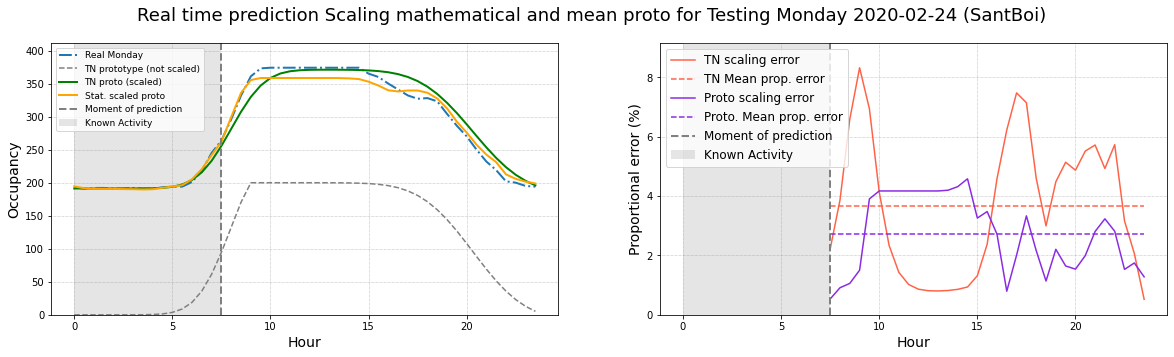

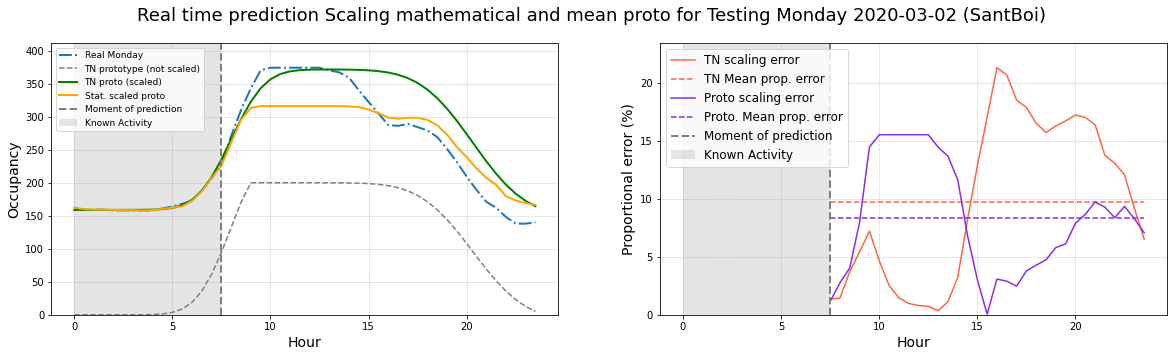

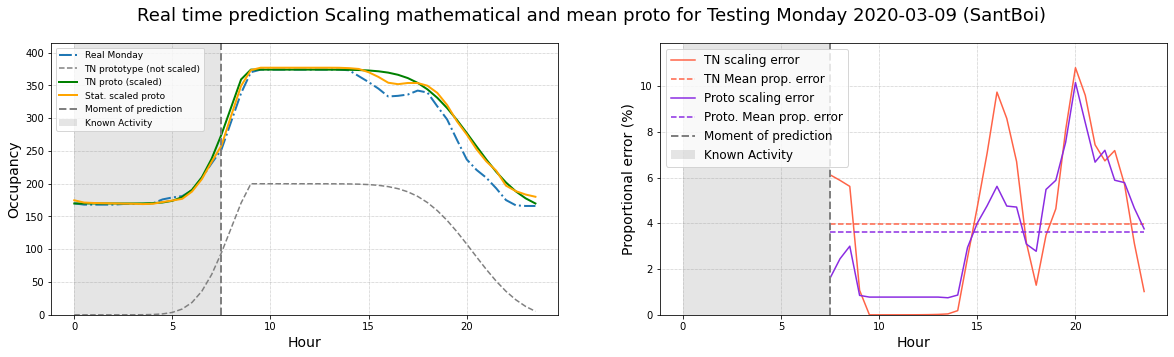

In [124]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

In [125]:
starting_hour=7

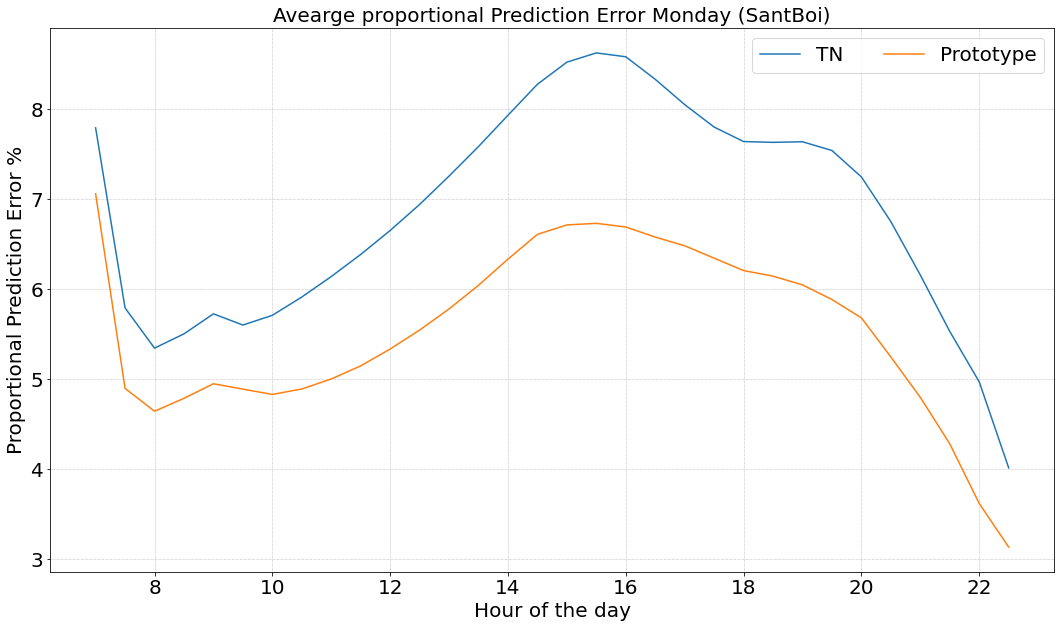

In [126]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [127]:
proto_running_error_wd=proto_running_error_vec
tn_running_error_wd=tn_running_error_vec

#### TUESDAY

In [128]:
statistic_proto = hist_weekday_proto
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 7.5
day = 'Tuesday'

In [129]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday

2020-02-25
82 cars could not park


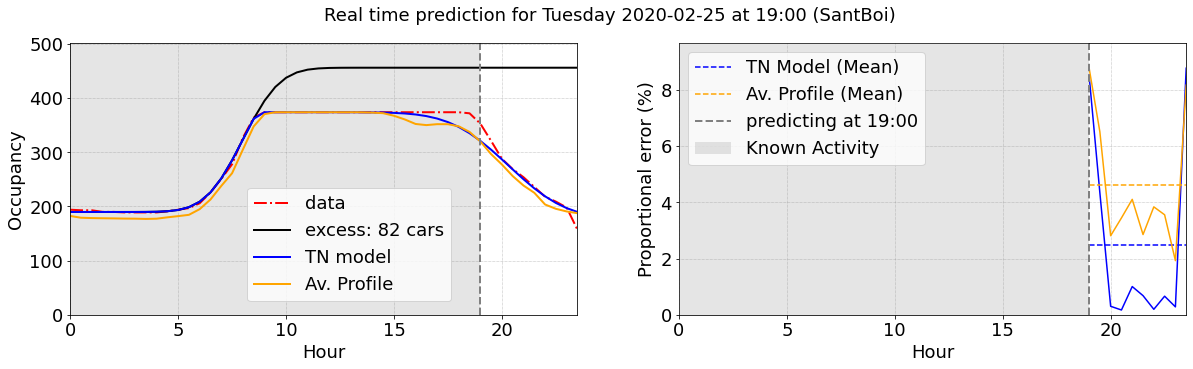

In [130]:
limit_hour = 19
fsize=18

if isinstance(limit_hour, int):
    hourstring = str(limit_hour) + ':00'
else:
    hourstring = str(int(limit_hour))+':'+str(int((limit_hour-int(limit_hour))*60))

for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
i=0

t_date=t_dates[cont]
print(t_date)
#tn_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_proto, max_value)
tn_arr_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_arr_proto)
stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

#scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]

scaled_tn_arr_proto_uncut=scaled_tn_arr_proto.copy()

if max(scaled_tn_arr_proto)>max_value:
    cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
    print(round(cars_could_not_park), "cars could not park")
    scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
    scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
else: 
    cars_could_not_park=0
    
scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

#scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
scaled_stat_proto = statistic_proto.values 
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(5)
axx=0;
time = np.linspace(0,23.5,48)
fig.suptitle('Real time prediction for '
             + day + ' ' +t_date + ' at '+ hourstring +' ('+ current_parking+')', fontsize=fsize)
ax[axx].plot(time, t_days[i].values, linestyle='dashdot', color='red', linewidth=2, label='data')
#ax[axx].plot(time, tn_proto,'--',color='grey', label='TN prototype (not scaled)')
if cars_could_not_park>0:
    ax[axx].plot(time, scaled_tn_arr_proto_uncut, color='black', linewidth=2, 
             label='excess: '+str(round(cars_could_not_park)) + ' cars')
ax[axx].plot(time, scaled_tn_proto2, color='blue', linewidth=2, label='TN model')
ax[axx].plot(time, scaled_stat_proto, color='orange', linewidth=2, label='Av. Profile')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2)
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].set_ylim([0,1.1*max([max(t_days[i].values),max(tn_proto),max(scaled_tn_proto2),
                             max(scaled_stat_proto),max(scaled_tn_arr_proto_uncut)])])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_xlim([0,23.5])
ax[axx].set_ylabel('Occupancy', fontsize=fsize)
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)
ax[axx].legend(fontsize=fsize,loc="best", bbox_to_anchor=(0.55,0.5))

#
axx=1;

limit_hourIdx = int(limit_hour*2)
tn_scaled_error = (np.absolute((np.array(scaled_tn_proto2) - np.array(t_days[i].values)))/max_value)*100
mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/max_value)*100

#tn_scaled_error = (np.absolute((np.array(scaled_tn_proto2) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100
#mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100

tn_s_error_mean = [np.mean(tn_scaled_error[limit_hourIdx:])]*len(tn_scaled_error)
mean_s_error_mean = [np.mean(mean_scaled_error[limit_hourIdx:])]*len(mean_scaled_error)

#Second plot
#     time = time[limit_hour:]
ax[axx].plot(time[limit_hourIdx:], tn_scaled_error[limit_hourIdx:], color='blue') #, label='TN Model')
ax[axx].plot(time[limit_hourIdx:],tn_s_error_mean[limit_hourIdx:], '--',color='blue', label='TN Model (Mean)')
ax[axx].plot(time[limit_hourIdx:],mean_scaled_error[limit_hourIdx:], color='orange')#, label='Average Profile')
ax[axx].plot(time[limit_hourIdx:],mean_s_error_mean[limit_hourIdx:], '--',color='orange', label='Av. Profile (Mean)')
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='predicting at '+ hourstring)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2, zorder=4, label='Known Activity')
ax[axx].set_xlim([0,23.5])
ax[axx].legend(fontsize=fsize)
ax[axx].set_ylim([0,1.1*max(max(tn_scaled_error[limit_hourIdx:]),max(mean_scaled_error[limit_hourIdx:]))])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_ylabel('Proportional error (%)', fontsize=fsize);
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)

fig.savefig('ExamplePrediction_'+current_parking+'TH_'+hourstring.replace(':','h') +'.pdf',bbox_inches='tight');

2020-02-25
82 cars could not park
Real Tuesday scaled prototype error:  2.54 %
Real Tuesday scaled prototype error (median):  0.67 %
Real Tuesday scaled prototype STDV: 3.5921418873692357
Real Tuesday scaled TN error:  2.5 %
Real Tuesday scaled TN error (median):  0.67 %
Real Tuesday scaled TN STDV:  3.295432480229375
_____________________________________________________________
2020-03-03
56 cars could not park
Real Tuesday scaled prototype error:  11.26 %
Real Tuesday scaled prototype error (median):  10.07 %
Real Tuesday scaled prototype STDV: 5.292318036621853
Real Tuesday scaled TN error:  12.66 %
Real Tuesday scaled TN error (median):  11.24 %
Real Tuesday scaled TN STDV:  4.427114091265197
_____________________________________________________________
2020-03-10
67 cars could not park
Real Tuesday scaled prototype error:  2.34 %
Real Tuesday scaled prototype error (median):  2.45 %
Real Tuesday scaled prototype STDV: 1.2819215358369047
Real Tuesday scaled TN error:  2.67 %
Real T

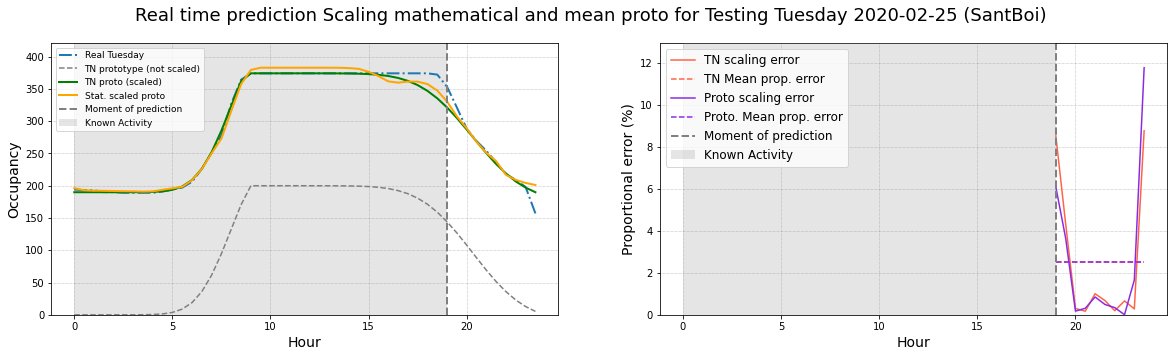

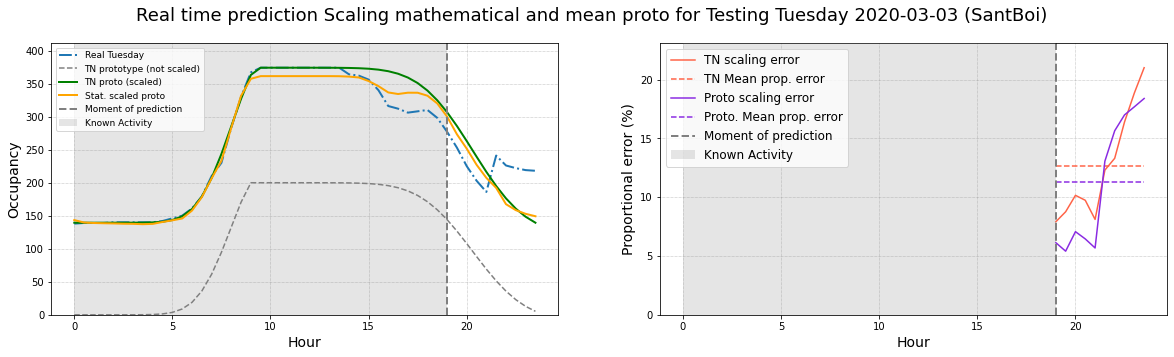

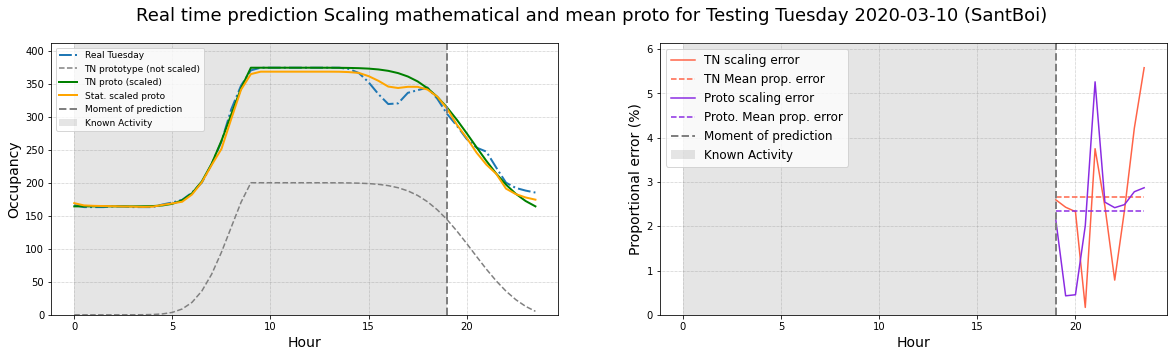

In [131]:

plot_prototype_fitTH()

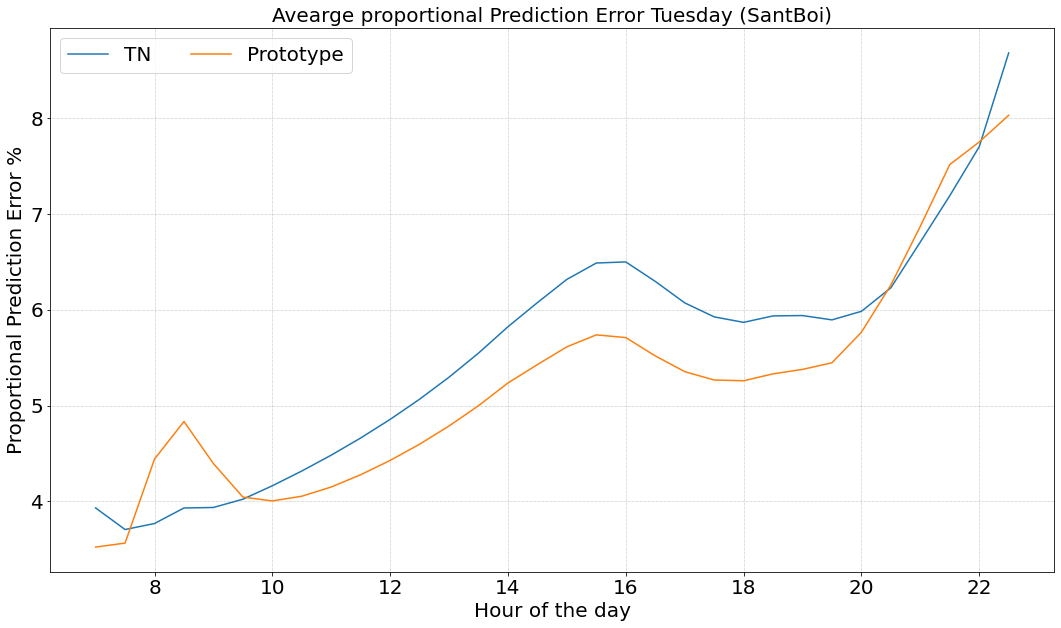

In [132]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [133]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

### WEDNESDAY

In [134]:
statistic_proto = hist_weekday_proto
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 7
day = 'Wednesday'

2020-02-26
Real Wednesday scaled prototype error:  4.43 %
Real Wednesday scaled prototype error (median):  2.72 %
Real Wednesday scaled prototype STDV: 4.146810365462452
Real Wednesday scaled TN error:  5.51 %
Real Wednesday scaled TN error (median):  4.38 %
Real Wednesday scaled TN STDV:  3.699158437456128
_____________________________________________________________
2020-03-04
117 cars could not park
Real Wednesday scaled prototype error:  2.98 %
Real Wednesday scaled prototype error (median):  2.39 %
Real Wednesday scaled prototype STDV: 2.23603702163017
Real Wednesday scaled TN error:  1.84 %
Real Wednesday scaled TN error (median):  1.15 %
Real Wednesday scaled TN STDV:  2.172871226730817
_____________________________________________________________
2020-03-11
140 cars could not park
Real Wednesday scaled prototype error:  3.9 %
Real Wednesday scaled prototype error (median):  4.62 %
Real Wednesday scaled prototype STDV: 2.3505147075873087
Real Wednesday scaled TN error:  2.02 %
R

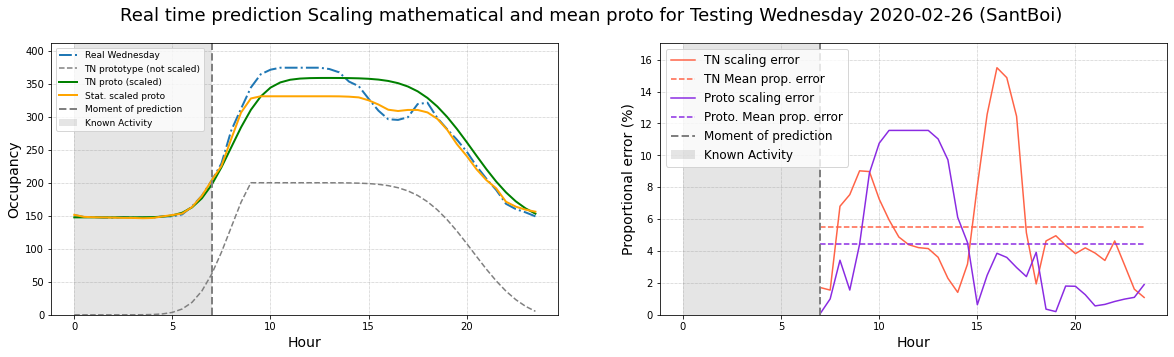

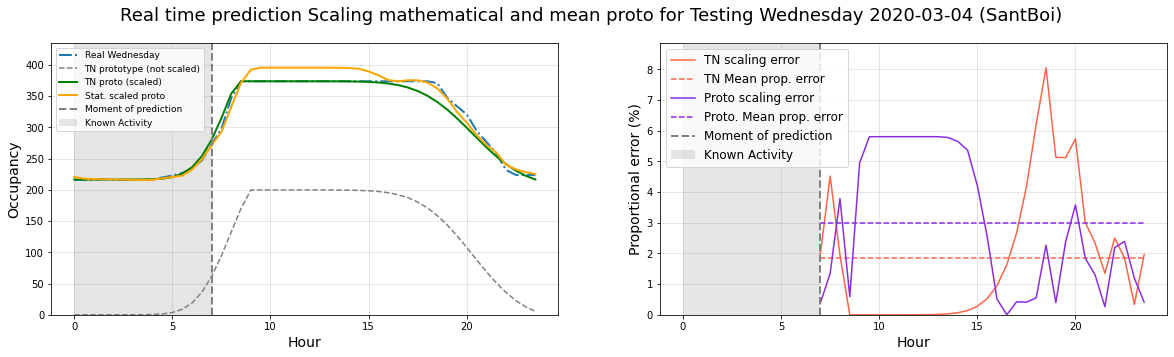

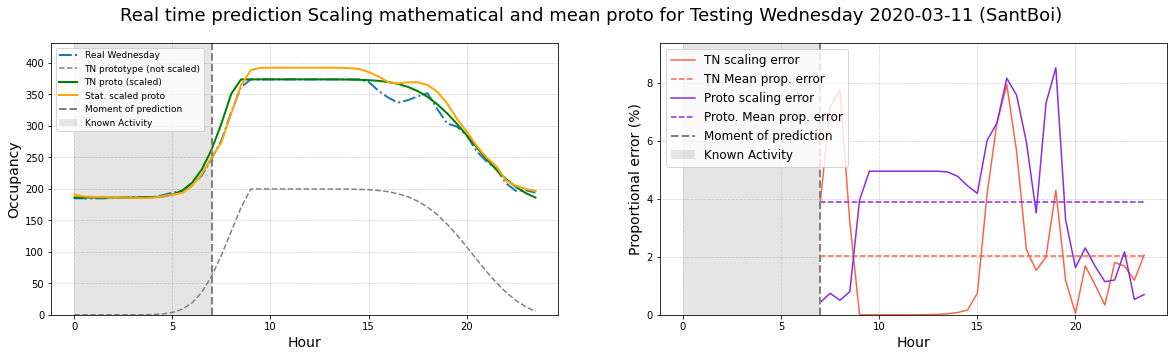

In [135]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

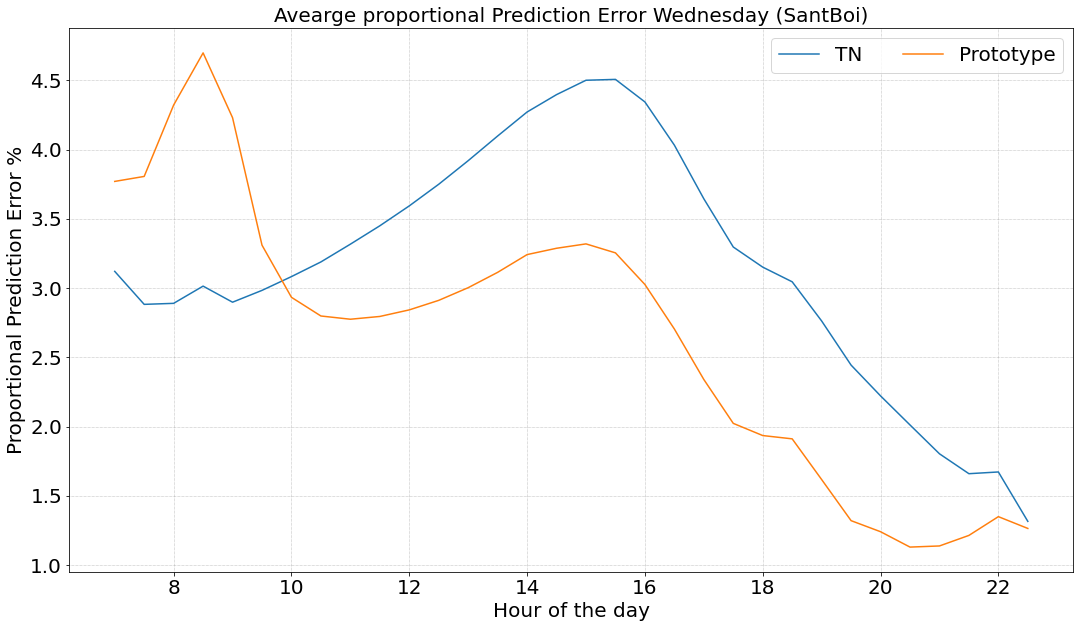

In [136]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [137]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

### THURSDAY

In [138]:
statistic_proto = hist_weekday_proto
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 7
day = 'Thursday'

2020-02-27
10 cars could not park
Real Thursday scaled prototype error:  4.38 %
Real Thursday scaled prototype error (median):  3.09 %
Real Thursday scaled prototype STDV: 3.8453827623710803
Real Thursday scaled TN error:  4.29 %
Real Thursday scaled TN error (median):  3.97 %
Real Thursday scaled TN STDV:  3.177997179402809
_____________________________________________________________
2020-03-05
168 cars could not park
Real Thursday scaled prototype error:  14.01 %
Real Thursday scaled prototype error (median):  13.68 %
Real Thursday scaled prototype STDV: 5.527301047140868
Real Thursday scaled TN error:  3.69 %
Real Thursday scaled TN error (median):  1.35 %
Real Thursday scaled TN STDV:  4.124735985706432
_____________________________________________________________
2020-03-12
55 cars could not park
Real Thursday scaled prototype error:  1.84 %
Real Thursday scaled prototype error (median):  2.22 %
Real Thursday scaled prototype STDV: 0.9303404653331917
Real Thursday scaled TN error

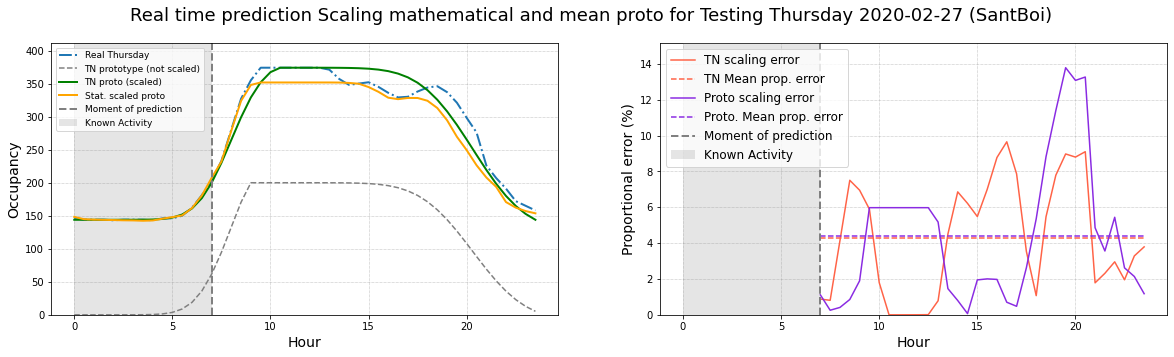

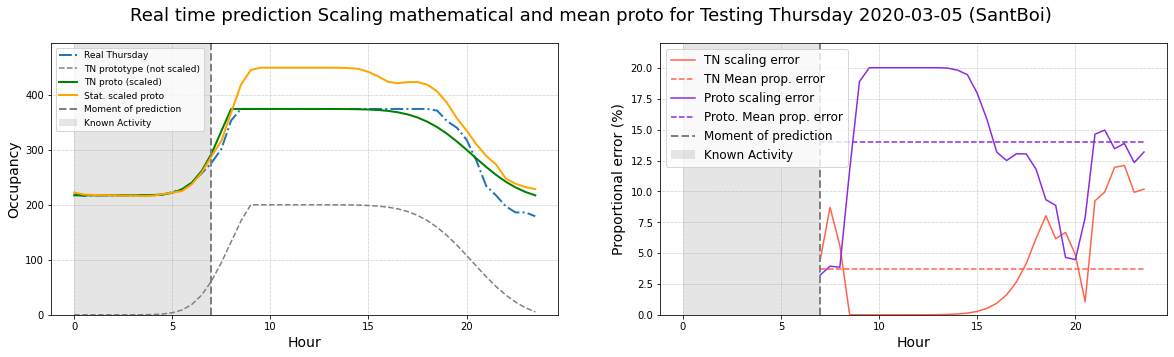

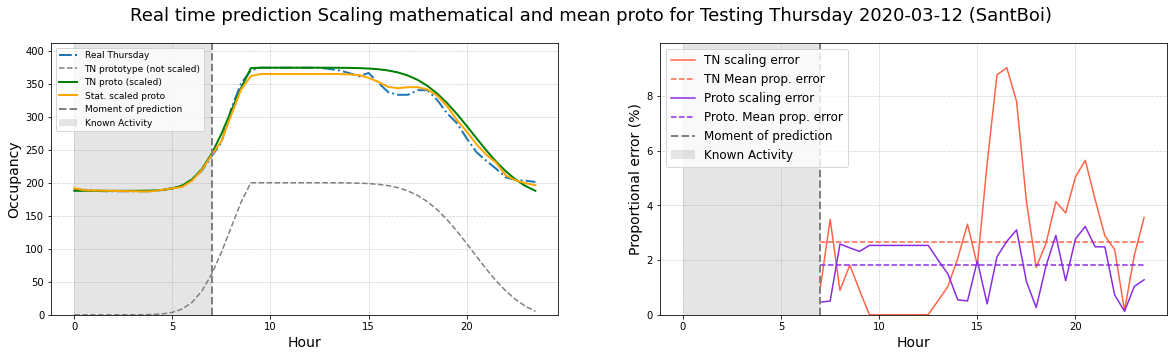

In [139]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

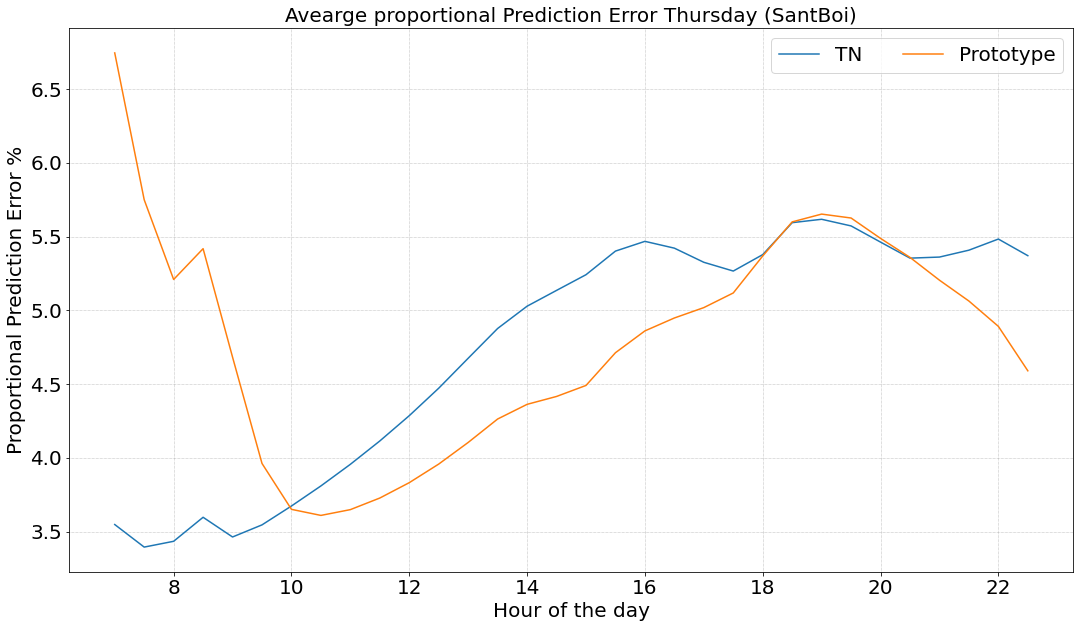

In [140]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [141]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

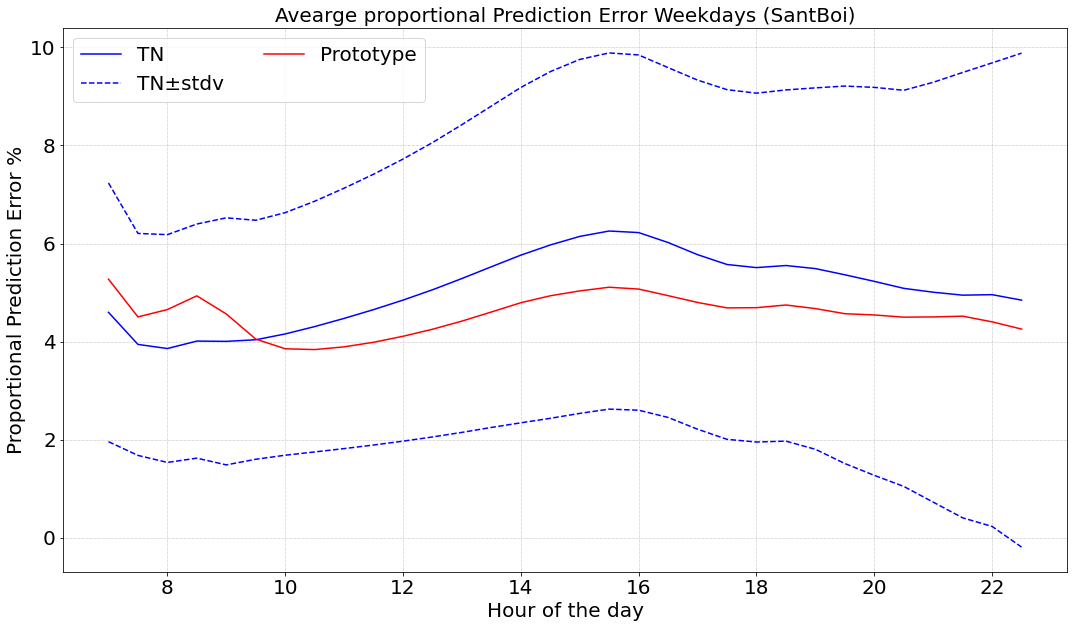

In [142]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_wd,proto_running_error_wd,starting_hour,"Weekdays",current_parking)

### FRIDAY

In [143]:
statistic_proto = hist_friday_proto
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'

2020-02-28
835 cars could not park
Real Friday scaled prototype error:  6.71 %
Real Friday scaled prototype error (median):  6.07 %
Real Friday scaled prototype STDV: 4.032204168601419
Real Friday scaled TN error:  14.59 %
Real Friday scaled TN error (median):  14.4 %
Real Friday scaled TN STDV:  7.566561849833696
_____________________________________________________________
2020-03-06
1067 cars could not park
Real Friday scaled prototype error:  2.88 %
Real Friday scaled prototype error (median):  2.68 %
Real Friday scaled prototype STDV: 1.9503508341757017
Real Friday scaled TN error:  7.65 %
Real Friday scaled TN error (median):  7.92 %
Real Friday scaled TN STDV:  5.3044111685757205
_____________________________________________________________
2020-03-13
155 cars could not park
Real Friday scaled prototype error:  17.11 %
Real Friday scaled prototype error (median):  17.85 %
Real Friday scaled prototype STDV: 1.9215553369198008
Real Friday scaled TN error:  23.15 %
Real Friday scal

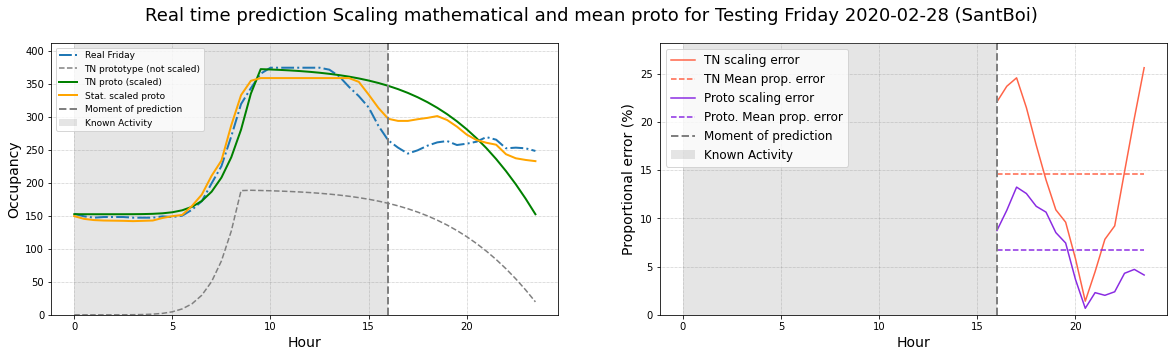

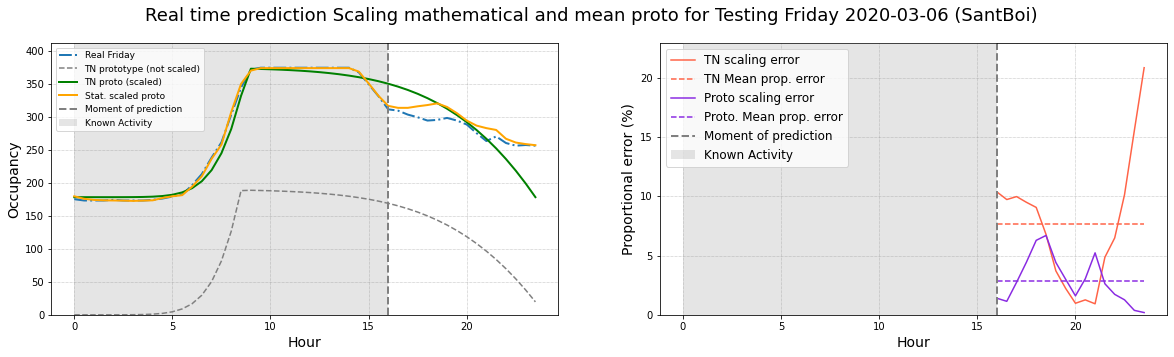

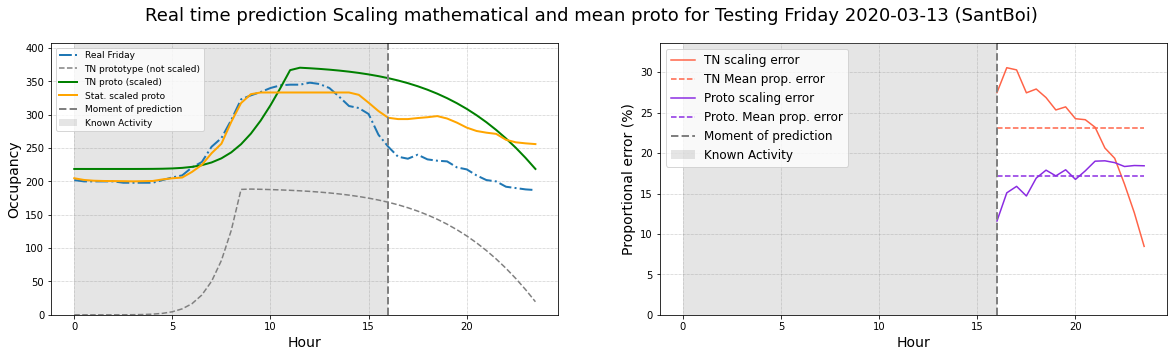

In [144]:
tn_proto = tn_friday_nooff

tn_arr_proto = tn_arr_friday_nooff
tn_dep_proto = tn_dep_friday
plot_prototype_fitTH()

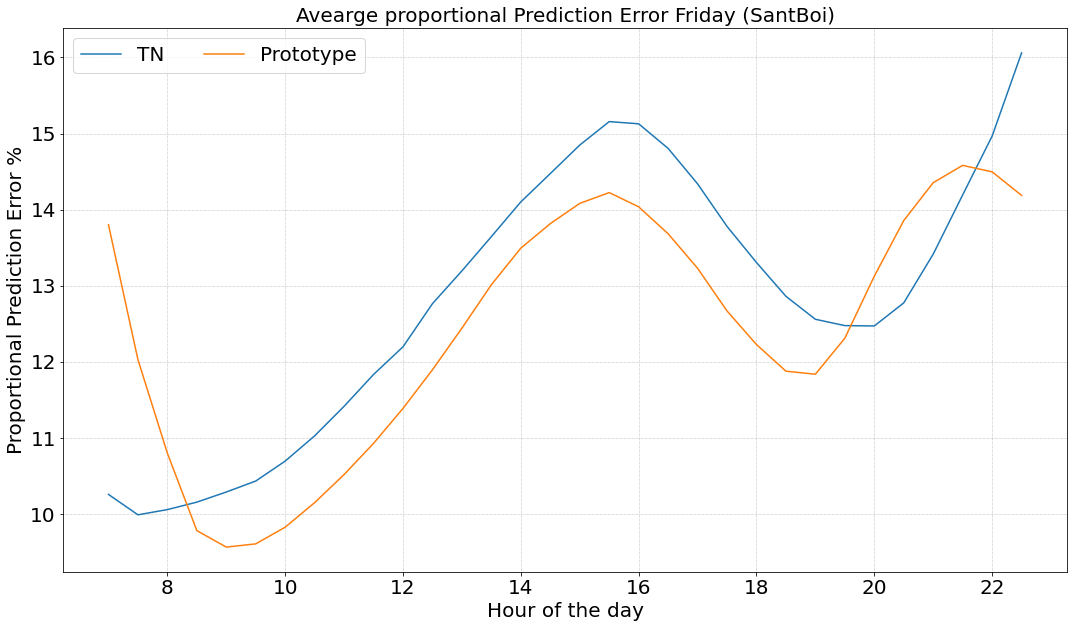

In [145]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [146]:
proto_running_error_fr=proto_running_error_vec
tn_running_error_fr=tn_running_error_vec

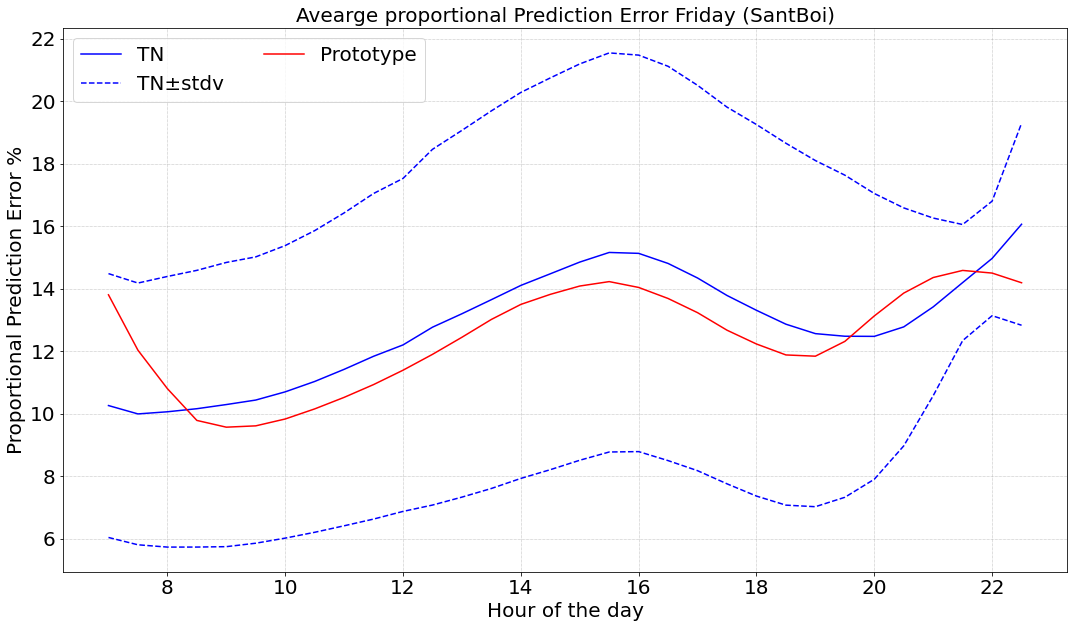

In [147]:

figH=plotRunningPredcitionErrorSTDV(tn_running_error_fr,proto_running_error_fr,starting_hour,day,current_parking)

### WEEKEND

### SATURDAY

In [148]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-22
Real Saturday scaled prototype error:  10.5 %
Real Saturday scaled prototype error (median):  10.36 %
Real Saturday scaled prototype STDV: 1.545260909372662
Real Saturday scaled TN error:  5.17 %
Real Saturday scaled TN error (median):  5.22 %
Real Saturday scaled TN STDV:  3.2586786844246305
_____________________________________________________________
2020-02-29
Real Saturday scaled prototype error:  7.97 %
Real Saturday scaled prototype error (median):  8.17 %
Real Saturday scaled prototype STDV: 1.8174472972124391
Real Saturday scaled TN error:  5.69 %
Real Saturday scaled TN error (median):  6.61 %
Real Saturday scaled TN STDV:  2.586822746868025
_____________________________________________________________
2020-03-07
Real Saturday scaled prototype error:  13.15 %
Real Saturday scaled prototype error (median):  12.52 %
Real Saturday scaled prototype STDV: 2.7498654620765954
Real Saturday scaled TN error:  7.61 %
Real Saturday scaled TN error (median):  5.98 %
Real Satur

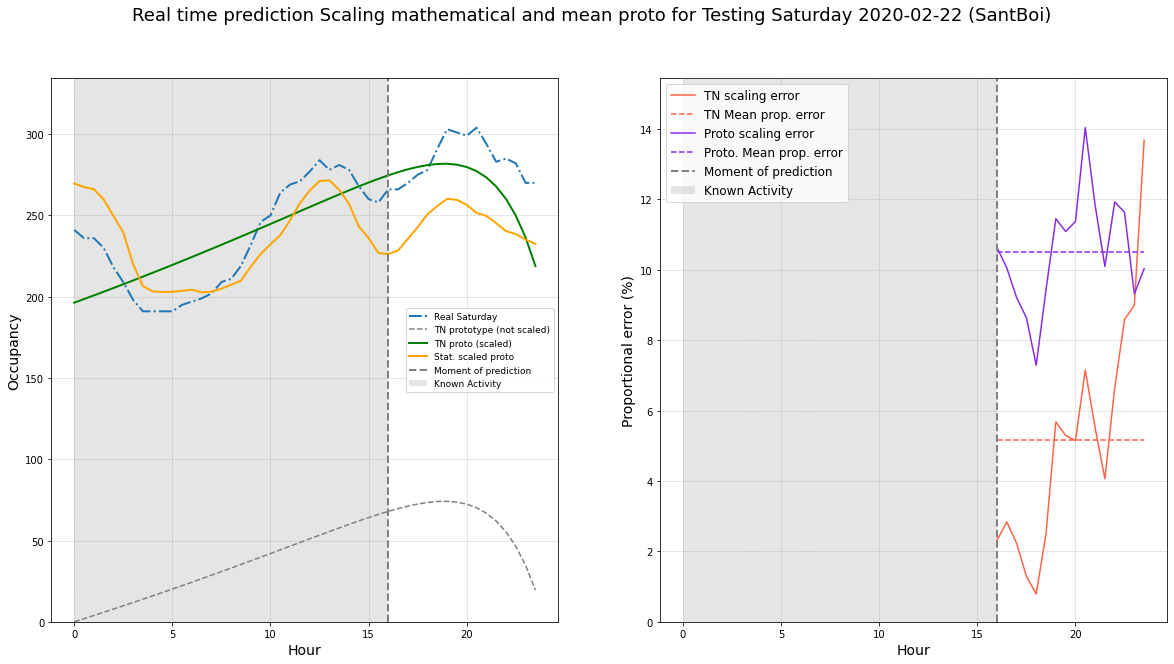

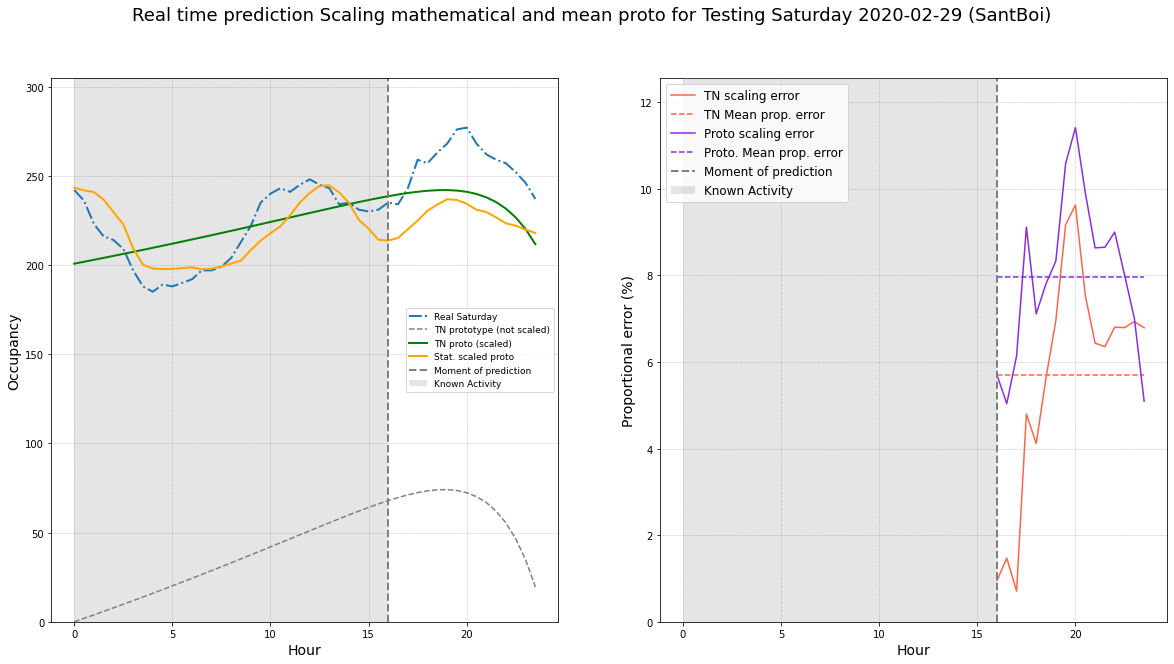

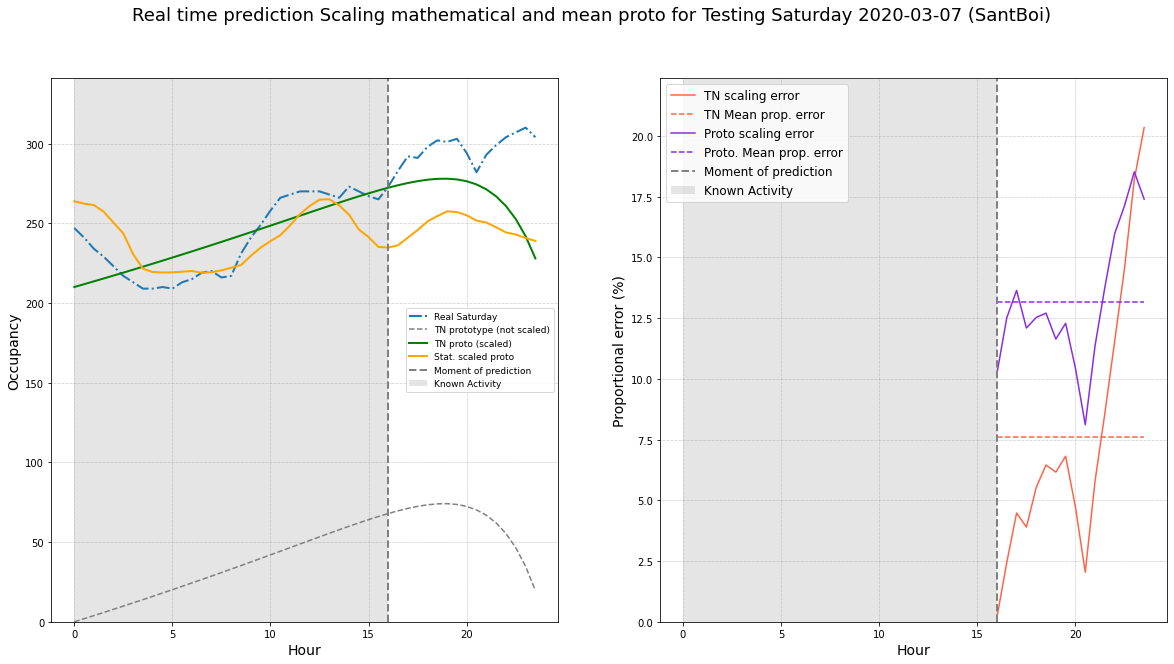

In [149]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

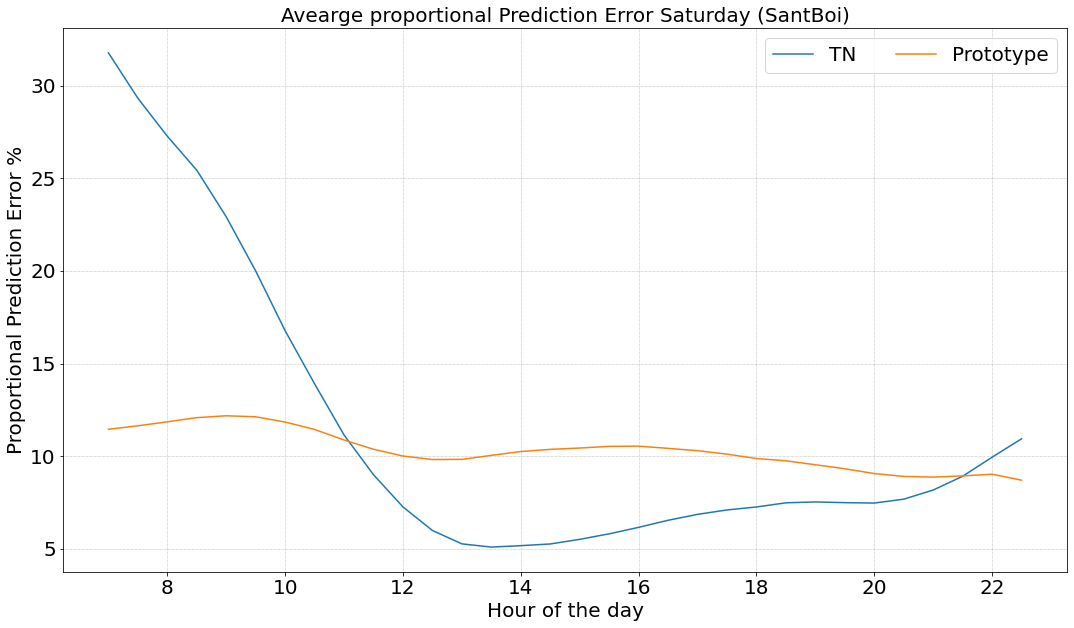

In [150]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [151]:
proto_running_error_we=proto_running_error_vec
tn_running_error_we=tn_running_error_vec

2020-02-22
Real Saturday scaled prototype error:  1.2 %
Real Saturday scaled prototype error (median):  0.86 %
Real Saturday scaled prototype STDV: 1.0680492543208813
Real Saturday scaled TN error:  6.16 %
Real Saturday scaled TN error (median):  7.7 %
Real Saturday scaled TN STDV:  4.144420355816149
_____________________________________________________________
2020-02-29
Real Saturday scaled prototype error:  1.26 %
Real Saturday scaled prototype error (median):  1.13 %
Real Saturday scaled prototype STDV: 0.9964097184320123
Real Saturday scaled TN error:  6.89 %
Real Saturday scaled TN error (median):  7.66 %
Real Saturday scaled TN STDV:  3.54752548840651
_____________________________________________________________
2020-03-07
Real Saturday scaled prototype error:  2.83 %
Real Saturday scaled prototype error (median):  2.16 %
Real Saturday scaled prototype STDV: 2.169227552661361
Real Saturday scaled TN error:  7.59 %
Real Saturday scaled TN error (median):  5.71 %
Real Saturday sca

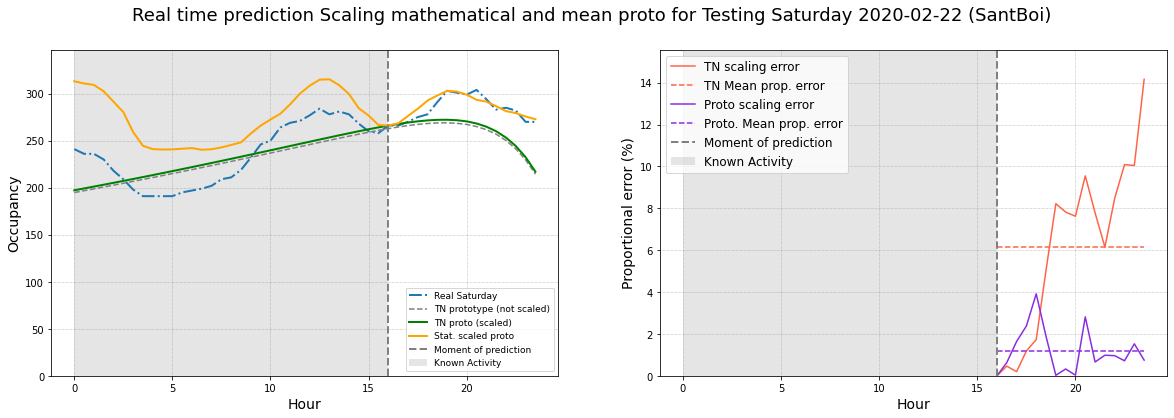

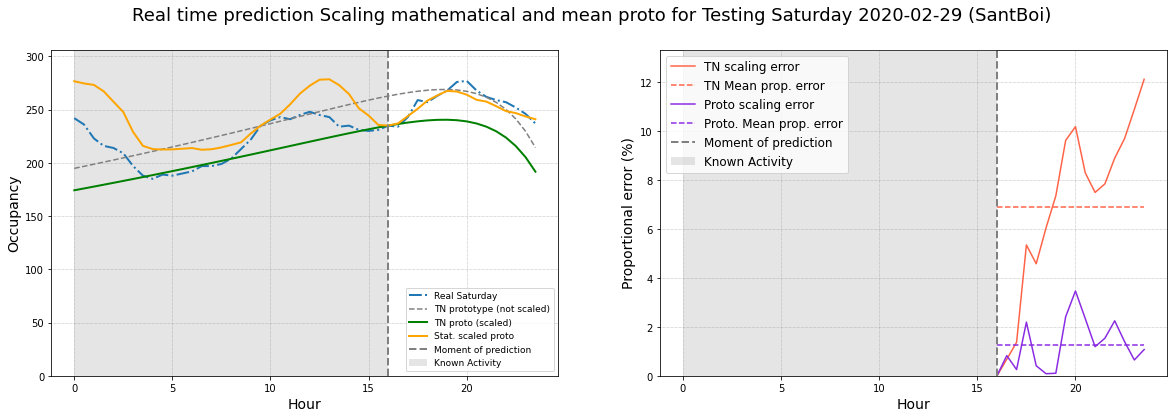

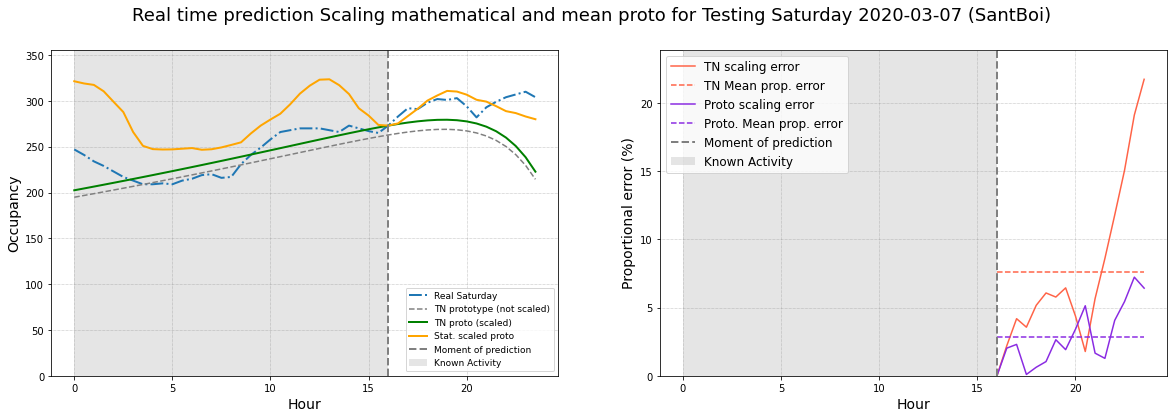

In [152]:
tn_proto = tn1_weekend   
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

In [153]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-23
Real Sunday scaled prototype error:  4.09 %
Real Sunday scaled prototype error (median):  3.57 %
Real Sunday scaled prototype STDV: 3.0238452367884117
Real Sunday scaled TN error:  6.67 %
Real Sunday scaled TN error (median):  5.47 %
Real Sunday scaled TN STDV:  4.933689751838003
_____________________________________________________________
2020-03-01
Real Sunday scaled prototype error:  16.54 %
Real Sunday scaled prototype error (median):  12.89 %
Real Sunday scaled prototype STDV: 12.019447333479965
Real Sunday scaled TN error:  15.34 %
Real Sunday scaled TN error (median):  13.57 %
Real Sunday scaled TN STDV:  8.545266354411499
_____________________________________________________________
2020-03-08
Real Sunday scaled prototype error:  9.42 %
Real Sunday scaled prototype error (median):  8.51 %
Real Sunday scaled prototype STDV: 4.683000112447887
Real Sunday scaled TN error:  14.26 %
Real Sunday scaled TN error (median):  12.03 %
Real Sunday scaled TN STDV:  8.51676809847

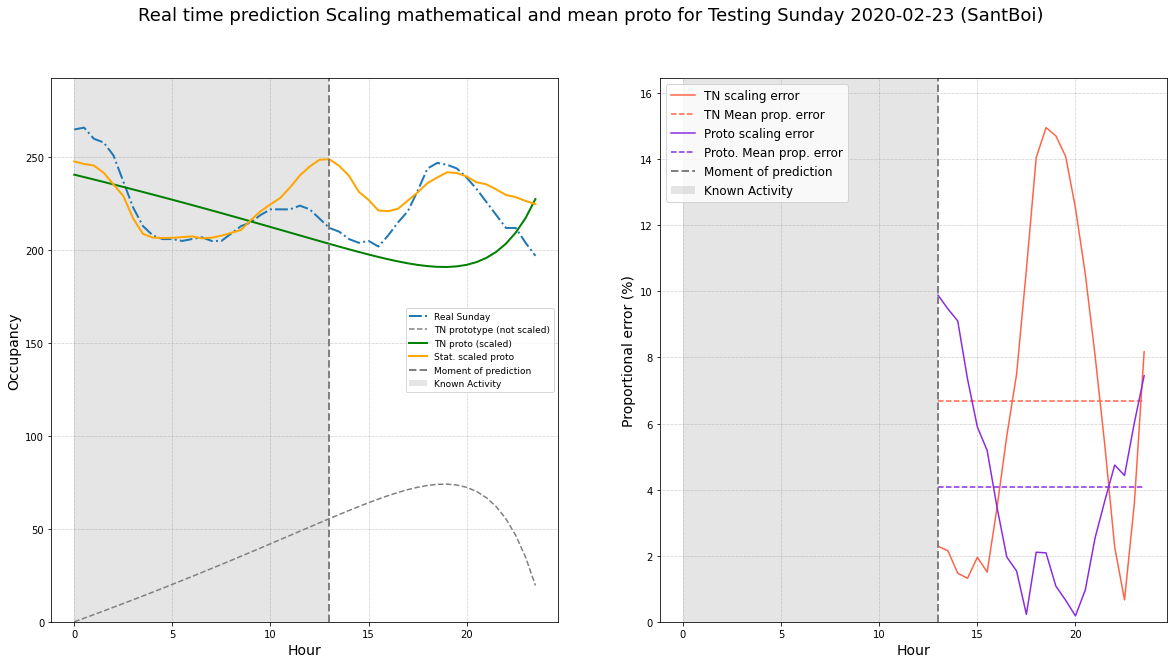

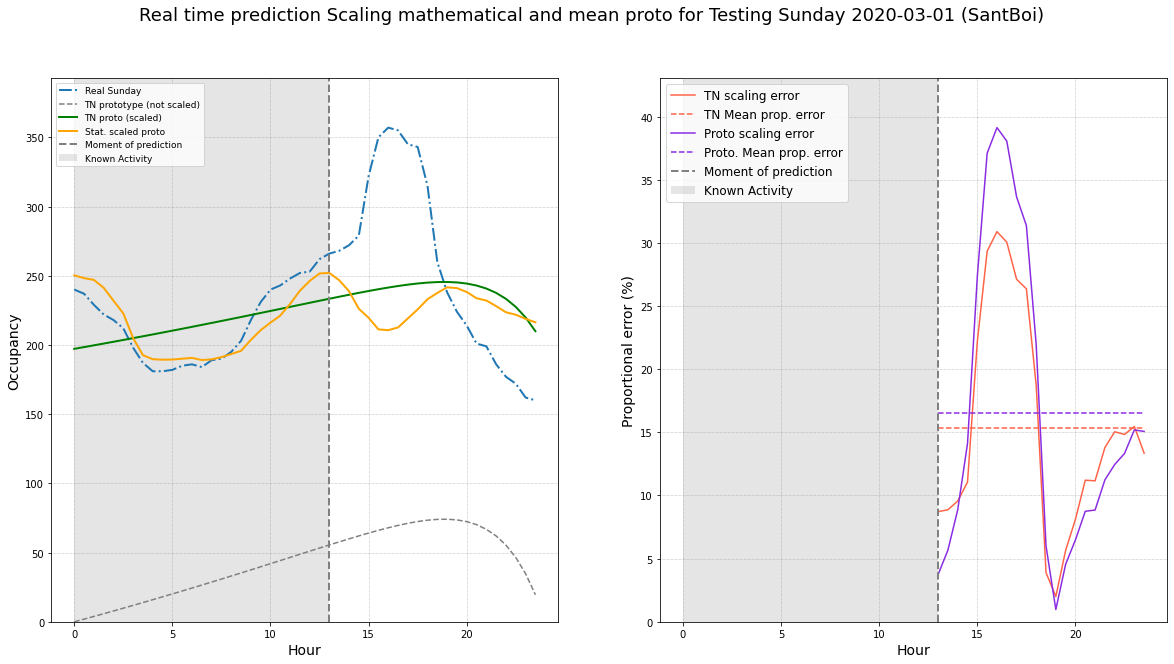

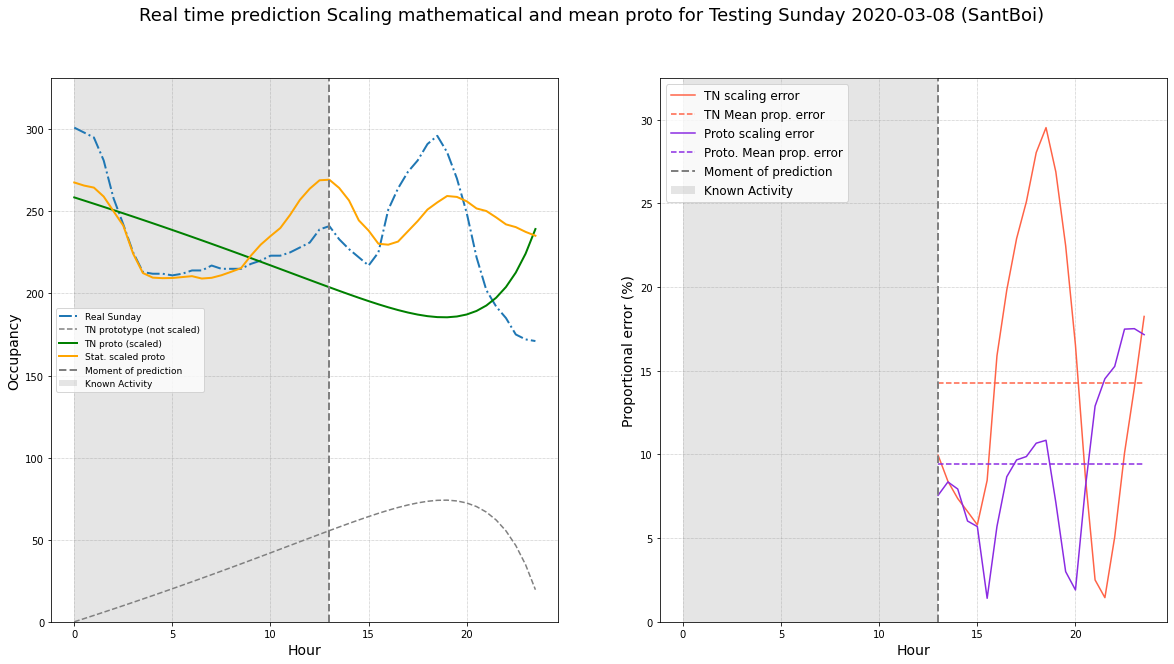

In [154]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

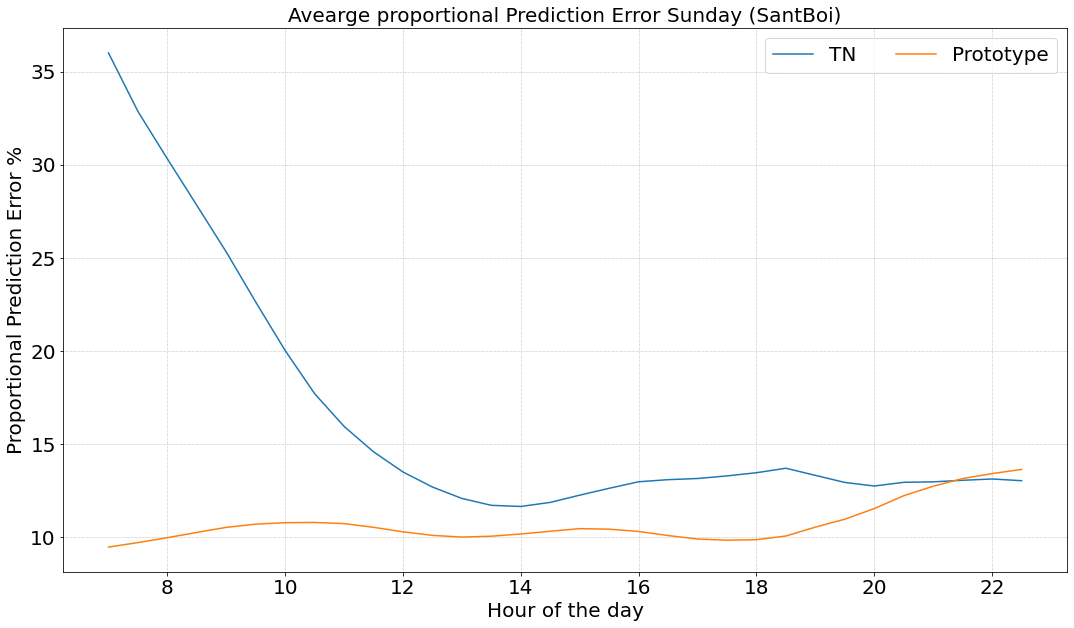

In [155]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [156]:
proto_running_error_we=np.concatenate((proto_running_error_we, proto_running_error_vec), axis=1)
tn_running_error_we=np.concatenate((tn_running_error_we, tn_running_error_vec), axis=1)

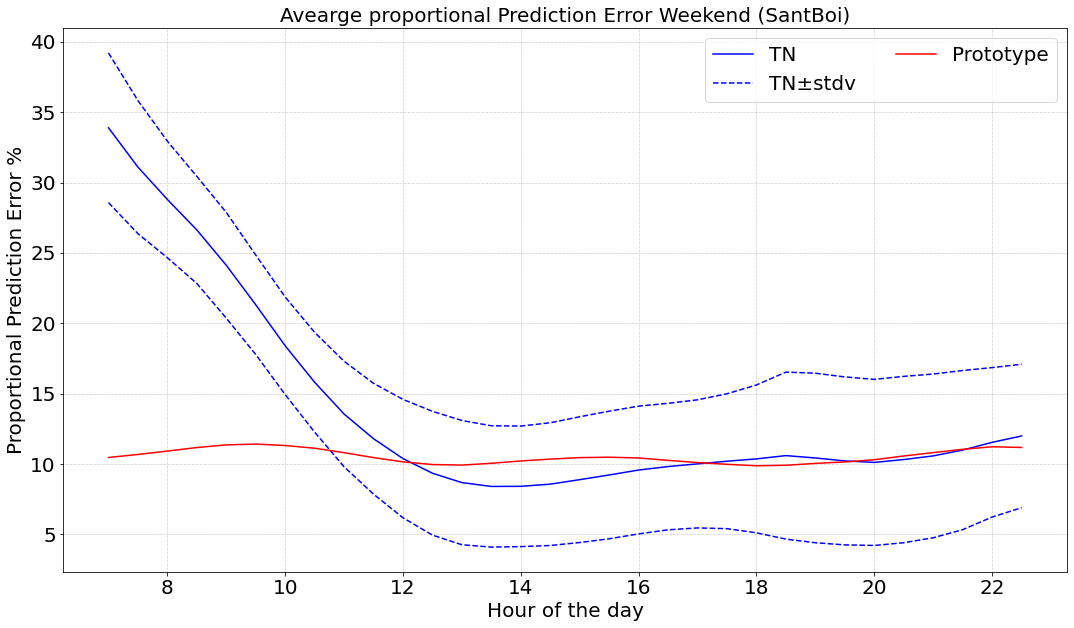

In [157]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_we,proto_running_error_we,starting_hour,"Weekend",current_parking)

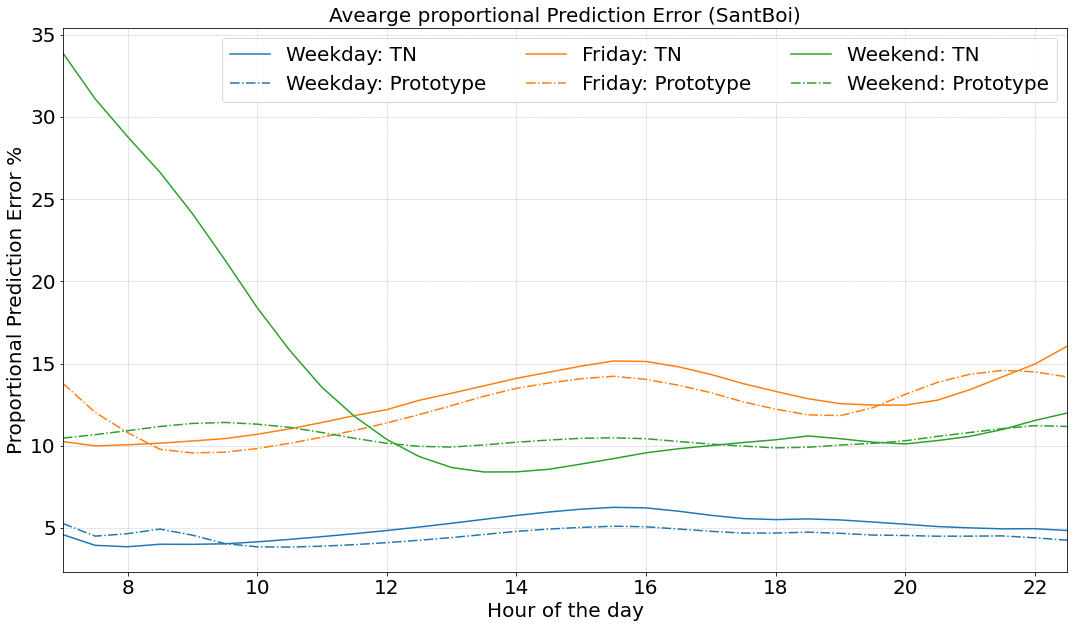

In [158]:
figH=plotRunningPredcitionErrorAgg(tn_running_error_wd,proto_running_error_wd,tn_running_error_fr,
                                  proto_running_error_fr,tn_running_error_we,proto_running_error_we,
                                  starting_hour,current_parking,False)
figH.savefig('RunningPredictionError_'+current_parking+'TH.pdf',bbox_inches='tight');